In [312]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score,r2_score
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [313]:
data = "processed_dataset.csv"
# processed_dataset_powerprod.csv       Classifies outliers, this means additional features in model, with the goal of fitting the model better to power production
# processed_dataset.csv      This file deletes all outliers, max pre-processing, deletes cp values etc

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [314]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [315]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

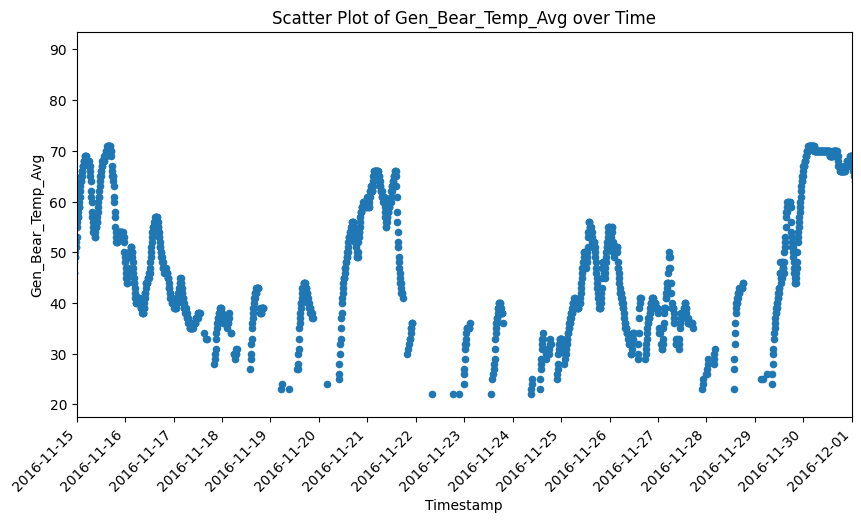

In [316]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


## Custom features

In [317]:
# creating data columns for the xgboost regressor

# Air density

# acceleration last x seconds

# Can we implement average speed for the last 30 minutes

# C_p?

# tip speed ratio

# Angle of blades

# Wind direction

# wind speed modified for distributed wind speed on diameter of blade

Air density 

In [318]:


# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df["T"] = merged_df["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df["p"] = merged_df["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df["e_s"] = 6.112 * np.exp((17.67 * merged_df["Amb_Temp_Avg"]) / (merged_df["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df["RH_frac"] = merged_df["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df["p_v"] = merged_df["RH_frac"] * merged_df["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df["p_d"] = merged_df["p"] - merged_df["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df["airdensity"] = (merged_df["p_d"] / (R_d * merged_df["T"])) + (merged_df["p_v"] / (R_v * merged_df["T"]))

# Optionally, drop intermediate columns if not needed
merged_df.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df[["airdensity"]].head())


   airdensity
0    1.193996
1    1.203438
2    1.203356
3    1.204229
4    1.194742


In [319]:
# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df17["T"] = merged_df17["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df17["p"] = merged_df17["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df17["e_s"] = 6.112 * np.exp((17.67 * merged_df17["Amb_Temp_Avg"]) / (merged_df17["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df17["RH_frac"] = merged_df17["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df17["p_v"] = merged_df17["RH_frac"] * merged_df17["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df17["p_d"] = merged_df17["p"] - merged_df17["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df17["airdensity"] = (merged_df17["p_d"] / (R_d * merged_df17["T"])) + (merged_df17["p_v"] / (R_v * merged_df17["T"]))

# Optionally, drop intermediate columns if not needed
merged_df17.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df17[["airdensity"]].head())


    airdensity
3     1.221427
12    1.225975
19    1.225897
21    1.226208
22    1.226286


(-50.0, 2100.0)

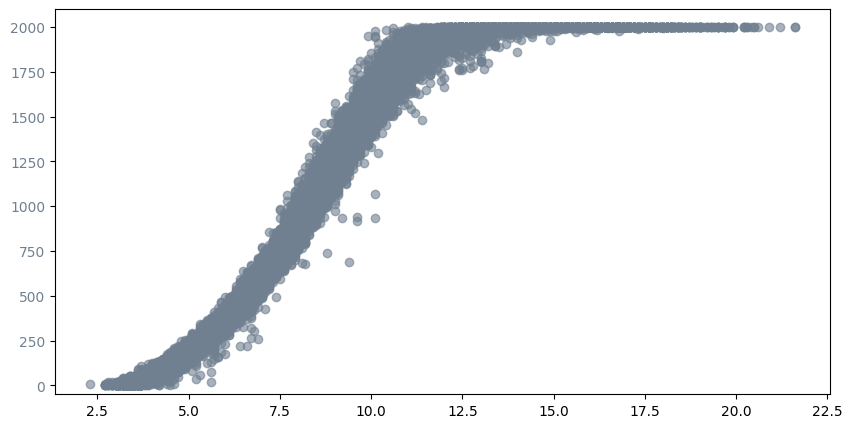

In [320]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["Grd_Prod_Pwr_Avg"], color='slategray', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)


### TSR 2016

In [321]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df["tsr"] = (merged_df["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df["Amb_WindSpeed_Avg"]

merged_df = merged_df[merged_df["Amb_WindSpeed_Avg"] != 0]

### TSR 2017

In [322]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df17["tsr"] = (merged_df17["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df17["Amb_WindSpeed_Avg"]

merged_df17 = merged_df17[merged_df17["Amb_WindSpeed_Avg"] != 0]

In [323]:
# calculate wind power column
# Calculate actual cp

"""Amb_Temp_Avg, Avg_AmbientTemp"""
Arotor = 6362 #m^2 rotor area

# new column for power in the wind itself. 
merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000 #kW

merged_df = merged_df[merged_df["p_wind"] != 0]
# cp = p_turbine / p_wind
merged_df["cp_actual"] =  merged_df["Grd_Prod_Pwr_Avg"] / merged_df["p_wind"]

merged_df = merged_df[merged_df["cp_actual"] != 0]

In [324]:
# calculate wind power column
# Calculate actual cp

# new column for power in the wind itself. 
merged_df17["p_wind"] = 0.5*merged_df17["airdensity"]*Arotor*(merged_df17["Amb_WindSpeed_Avg"]**3)/1000 #kW


## Xgboost model:

In [325]:
# Step 2: Specify the feature columns and the target variable
feature_columns = ["airdensity", "Amb_WindSpeed_Avg"]  # Features
target_column = 'Grd_Prod_Pwr_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model with optimal hyperparameters
model = XGBRegressor()


# Step 6: Train the model
model.fit(X_train, y_train)


# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)


# Step 8: Evaluate the model on merged_df (Optional)
train_predictions = model.predict(X_train)


# Check if the target variable is binary (classification)
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # Regression Metrics
    mse = mean_squared_error(y_train, train_predictions)
    mae = mean_absolute_error(y_train, train_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, train_predictions)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
    
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


Mean Squared Error (MSE): 1032.87
Mean Absolute Error (MAE): 21.97
Root Mean Squared Error (RMSE): 32.14
R² Score: 1.00
Mean Absolute Percentage Error (MAPE): 21.69%


In [326]:
# mean error of hybrid model
y_difference_xgboost = merged_df17["xgboost_pred_2017"] - merged_df17["Grd_Prod_Pwr_Avg"]

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_xgboost = np.abs(np.std(y_difference_xgboost))
modelling_error_xgboost

np.float64(206.6519511768951)

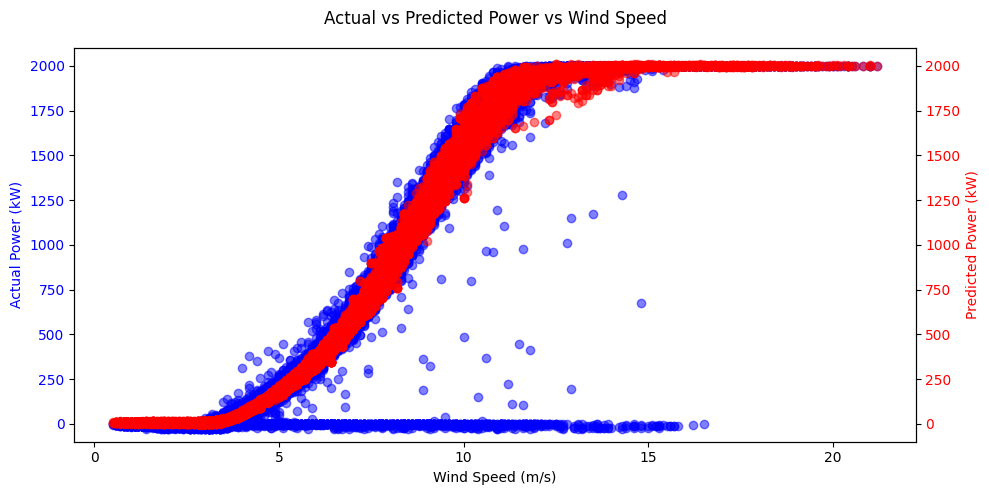

In [327]:
import matplotlib.pyplot as plt

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = merged_df17["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = merged_df17["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = merged_df17["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")
plt.ylim(-100,2100)
# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")


# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed")
fig.tight_layout()
plt.ylim(-100,2100)
plt.show()


### What does this look for a smaller period

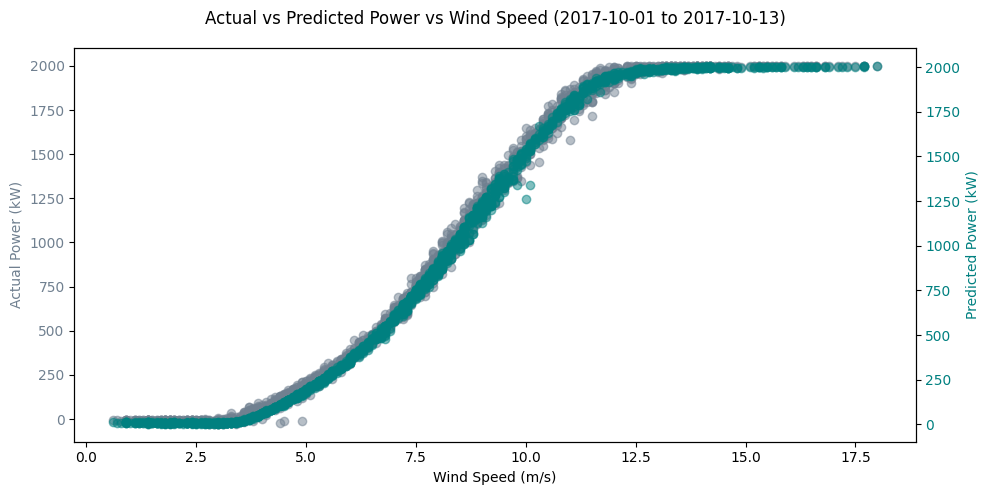

In [328]:
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Filter data for the date range 2017-10-01 to 2017-10-13
filtered_df = merged_df17[(merged_df17["Timestamp"] >= "2017-10-01") & 
                          (merged_df17["Timestamp"] <= "2017-10-13")]

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = filtered_df["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = filtered_df["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = filtered_df["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="slategrey")
ax1.scatter(x, y_actual, color="slategrey", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="slategrey")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="teal")
ax2.scatter(x, y_predicted, color="teal", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="teal")

# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed (2017-10-01 to 2017-10-13)")
fig.tight_layout()
plt.show()


In [329]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Compute metrics
mse = mean_squared_error(y_actual, y_predicted) 
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_actual, y_predicted) 
r2 = r2_score(y_actual, y_predicted) 
mape = mean_absolute_percentage_error(y_actual, y_predicted)
# Print metrics
print("Model Performance Metrics (2017-10-01 to 2017-10-13):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"MAPE Score: {mape:.4f}")
print(f"R² Score: {r2:.4f}")

Model Performance Metrics (2017-10-01 to 2017-10-13):
Mean Squared Error (MSE): 1315.61
Root Mean Squared Error (RMSE): 36.27
Mean Absolute Error (MAE): 25.13
MAPE Score: 0.6191
R² Score: 0.9976


### Error calculation

In [330]:
# error models

# total error = model error + sensor error + actual error + operational error



# mean error
y_difference_inference = y_predicted-y_actual

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_xgboost_inference = np.abs(np.std(y_difference_inference))

In [331]:
modelling_error_xgboost_inference

np.float64(36.239132612230435)

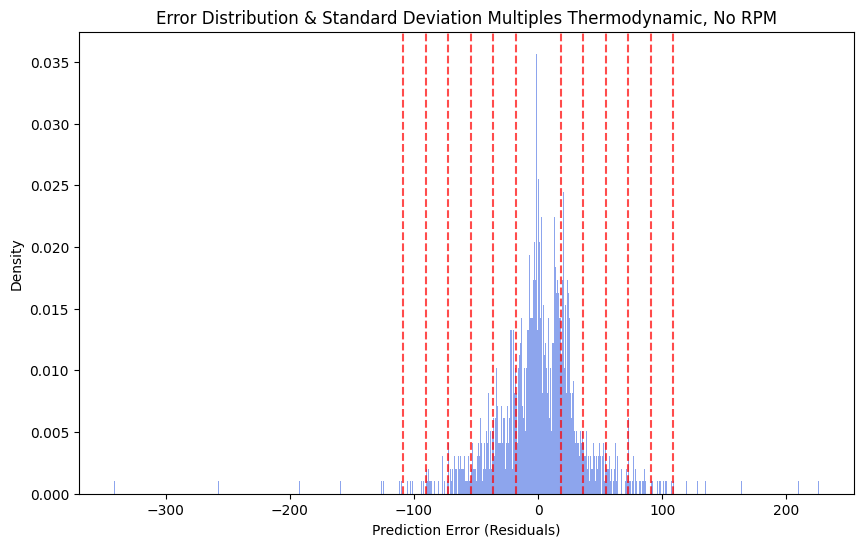

In [332]:

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines for standard deviation multiples
for m in multiples_of_sigma:
    plt.axvline(m * std_dev, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(-m * std_dev, color='red', linestyle='dashed', alpha=0.7)

plt.title("Error Distribution & Standard Deviation Multiples Thermodynamic, No RPM")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.show()


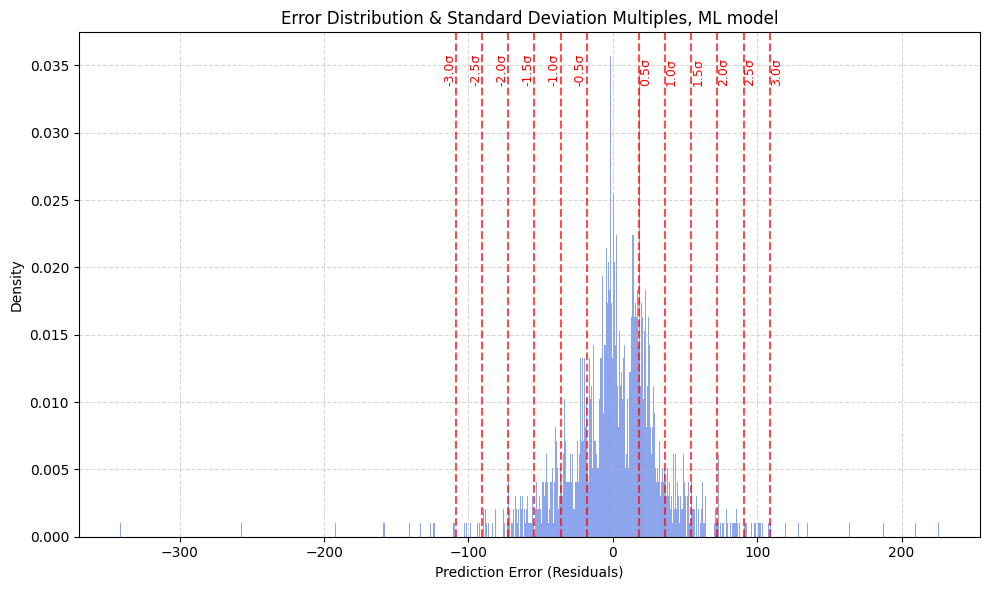

In [333]:
import matplotlib.pyplot as plt
import numpy as np

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines and text annotations for standard deviation multiples
for m in multiples_of_sigma:
    pos = m * std_dev
    neg = -m * std_dev
    plt.axvline(pos, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(neg, color='red', linestyle='dashed', alpha=0.7)
    plt.text(pos, plt.ylim()[1]*0.9, f'{m:.1f}σ', color='red', ha='left', fontsize=9, rotation=90)
    plt.text(neg, plt.ylim()[1]*0.9, f'-{m:.1f}σ', color='red', ha='right', fontsize=9, rotation=90)

plt.title("Error Distribution & Standard Deviation Multiples, ML model")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


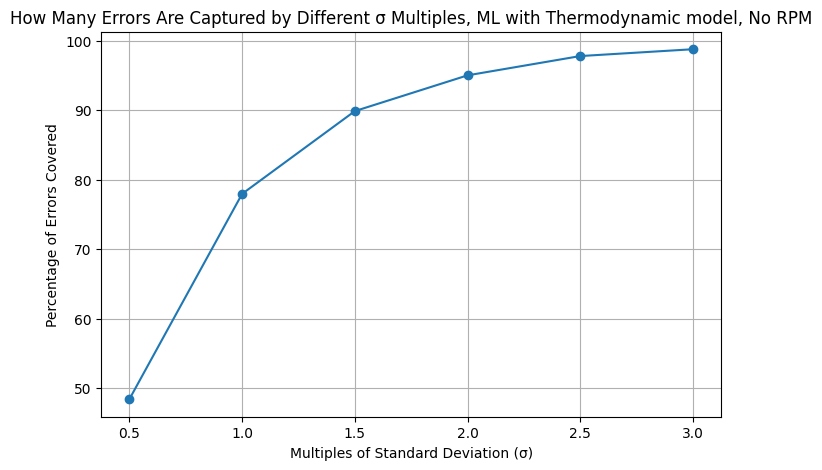

In [334]:
plt.figure(figsize=(8, 5))
plt.plot(multiples_of_sigma, coverage_percentages, marker='o', linestyle='-')

plt.xlabel("Multiples of Standard Deviation (σ)")
plt.ylabel("Percentage of Errors Covered")
plt.title("How Many Errors Are Captured by Different σ Multiples, ML with Thermodynamic model, No RPM")
plt.grid(True)

plt.show()


In [335]:
coverage_percentages

[np.float64(48.40948525159052),
 np.float64(77.96414112203585),
 np.float64(89.87854251012146),
 np.float64(95.02602660497398),
 np.float64(97.8021978021978),
 np.float64(98.78542510121457)]

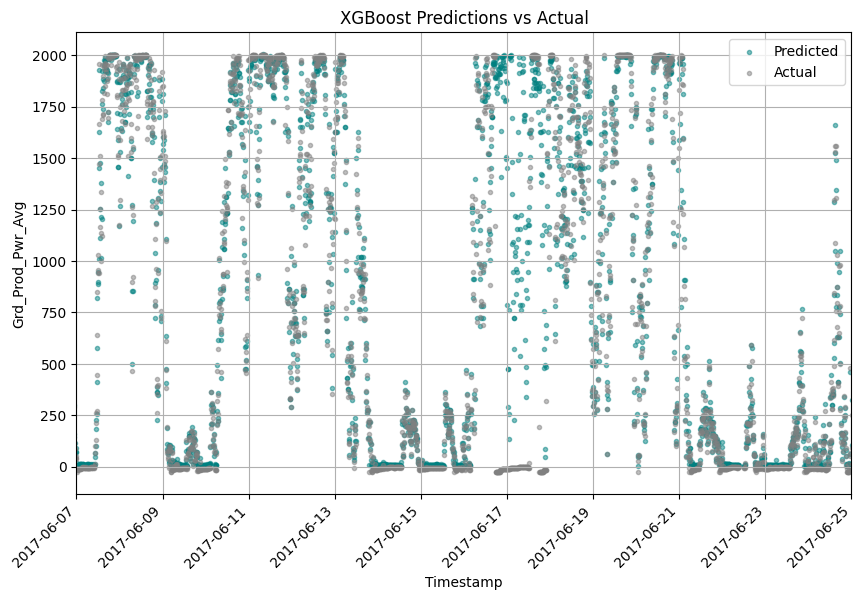

In [336]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


## Set maximum power here:

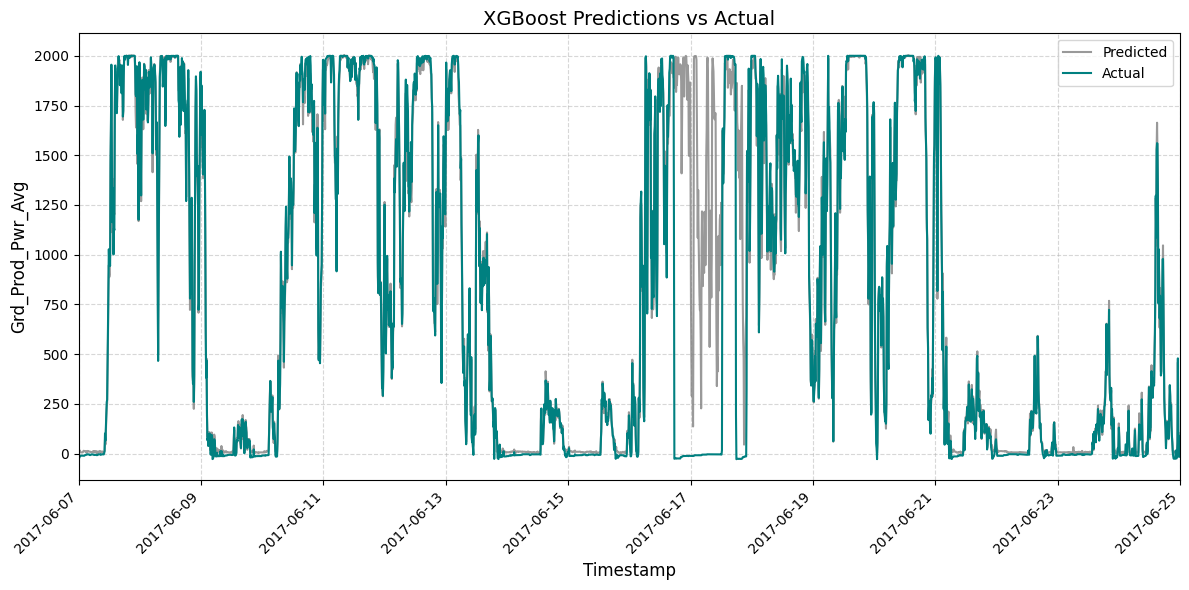

In [337]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Replication of maneesh work to see if data is faulty after maintenance in

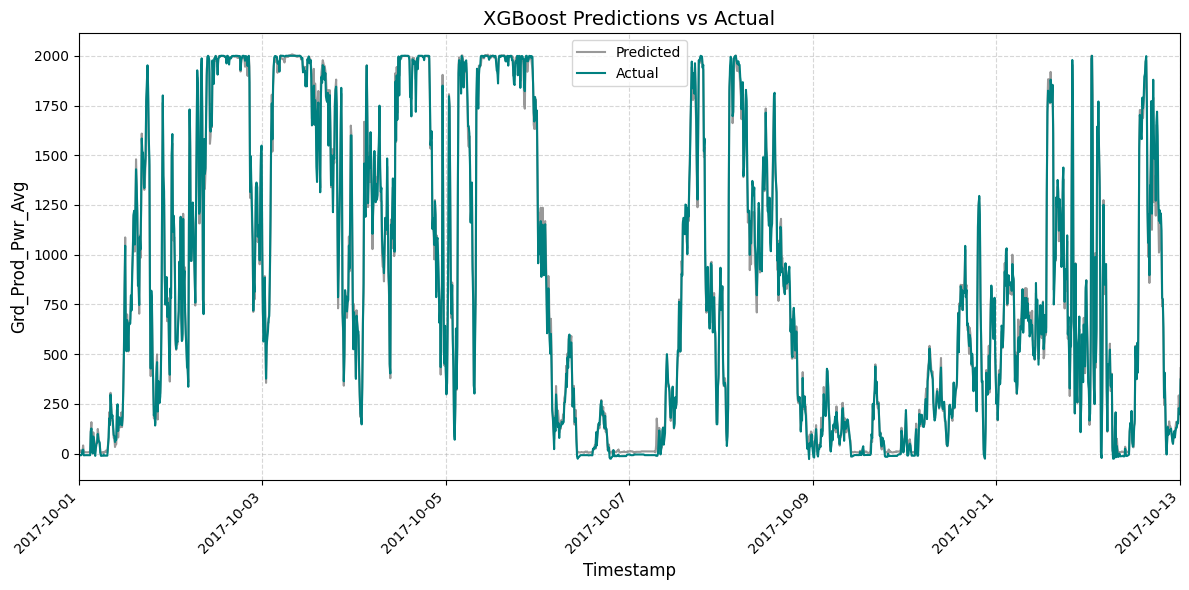

In [338]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


(np.float64(17324.0), np.float64(17525.0))

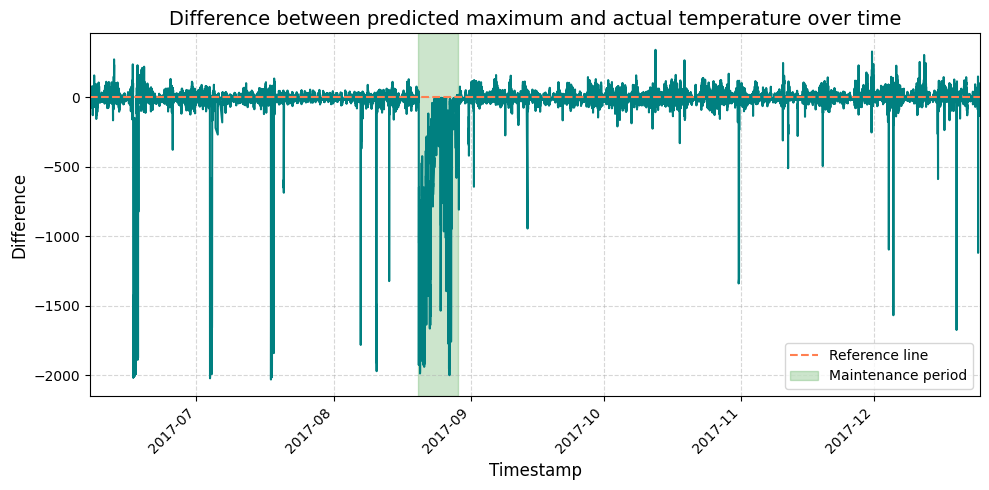

In [339]:
merged_df_filtered17_sorted["xgb_actual_diff"] =  merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]

plt.plot(merged_df_filtered17_sorted["Timestamp"],merged_df_filtered17_sorted["xgb_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")
# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")
# Configure plot
plt.title("Difference between predicted maximum and actual temperature over time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

Test of wide interval without uncertainty

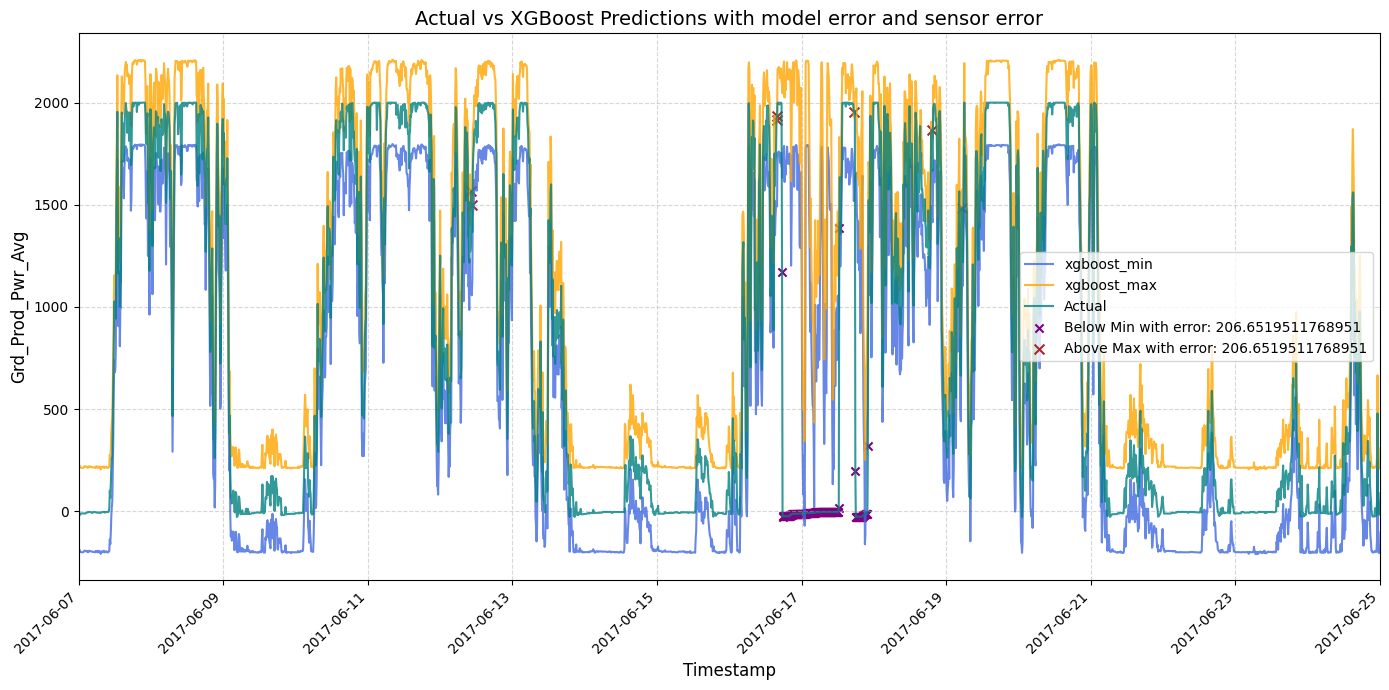

In [340]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - modelling_error_xgboost
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + modelling_error_xgboost

# Here we cap the maximum to be 2050


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"]).astype(int)

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below xgboost_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Min with error: {modelling_error_xgboost}'
)

# Scatter points where actual is above xgboost_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max with error: {modelling_error_xgboost}'
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))
plt.title("Actual vs XGBoost Predictions with model error and sensor error", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


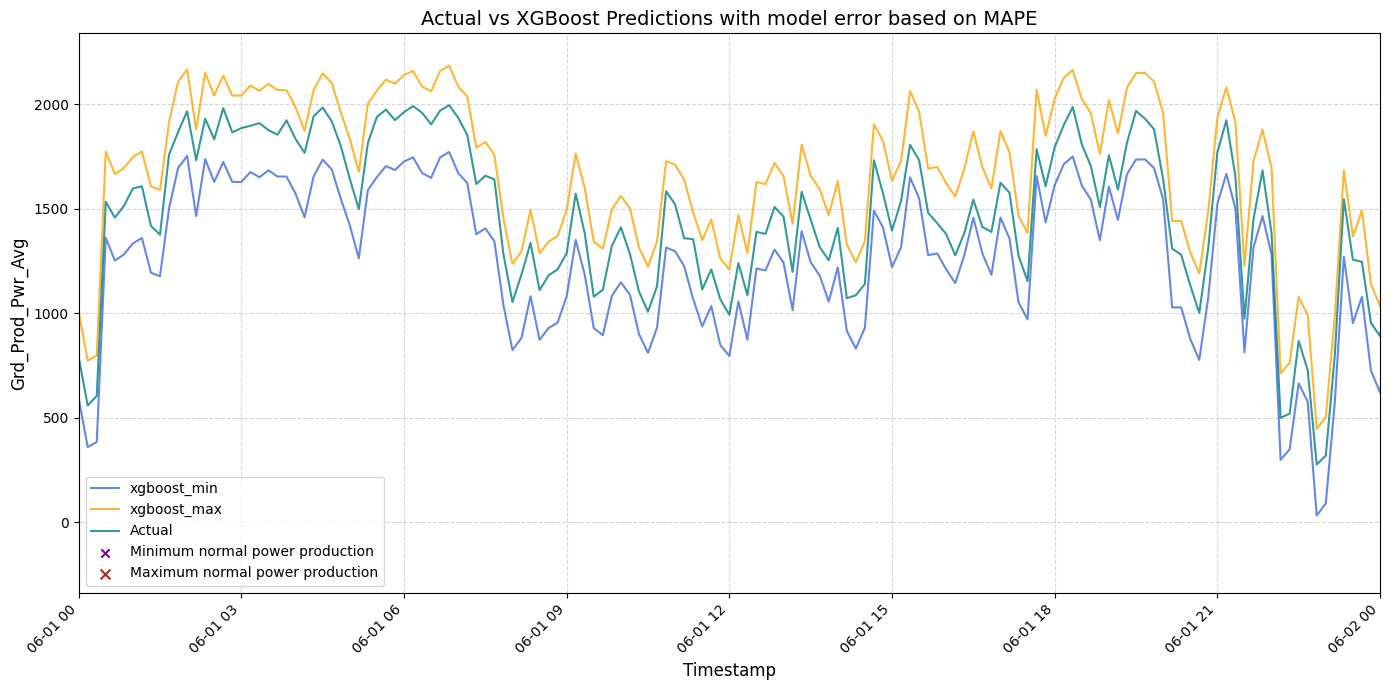

In [341]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - modelling_error_xgboost
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + modelling_error_xgboost


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"])
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"])

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], target_column],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], target_column],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)


# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-01'), pd.to_datetime('2017-06-02'))
plt.title("Actual vs XGBoost Predictions with model error based on MAPE", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


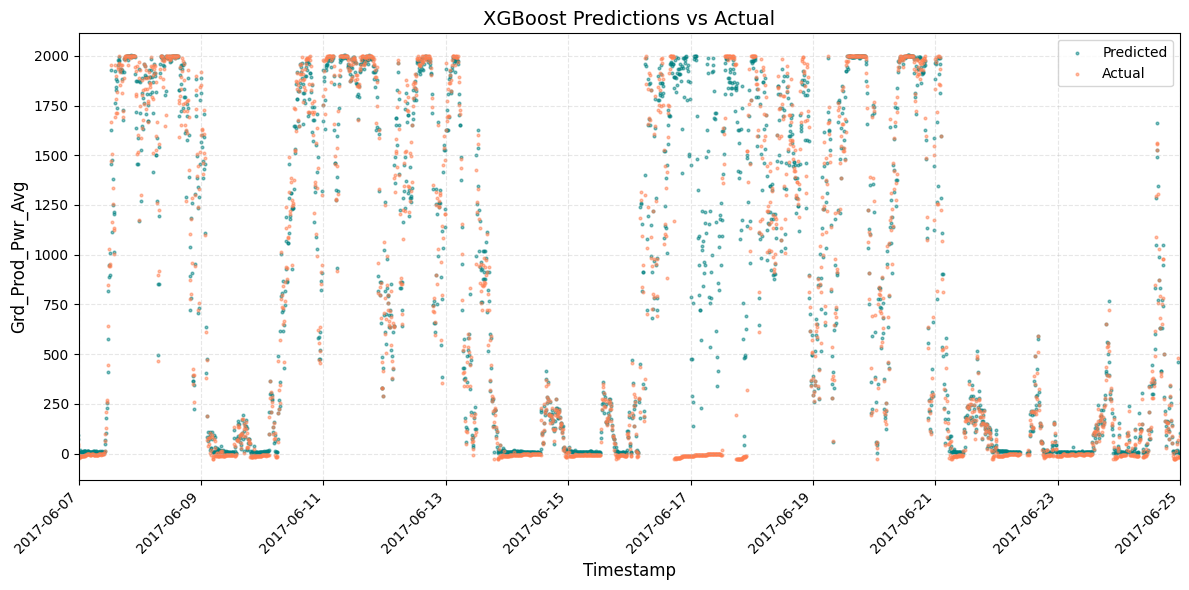

In [342]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


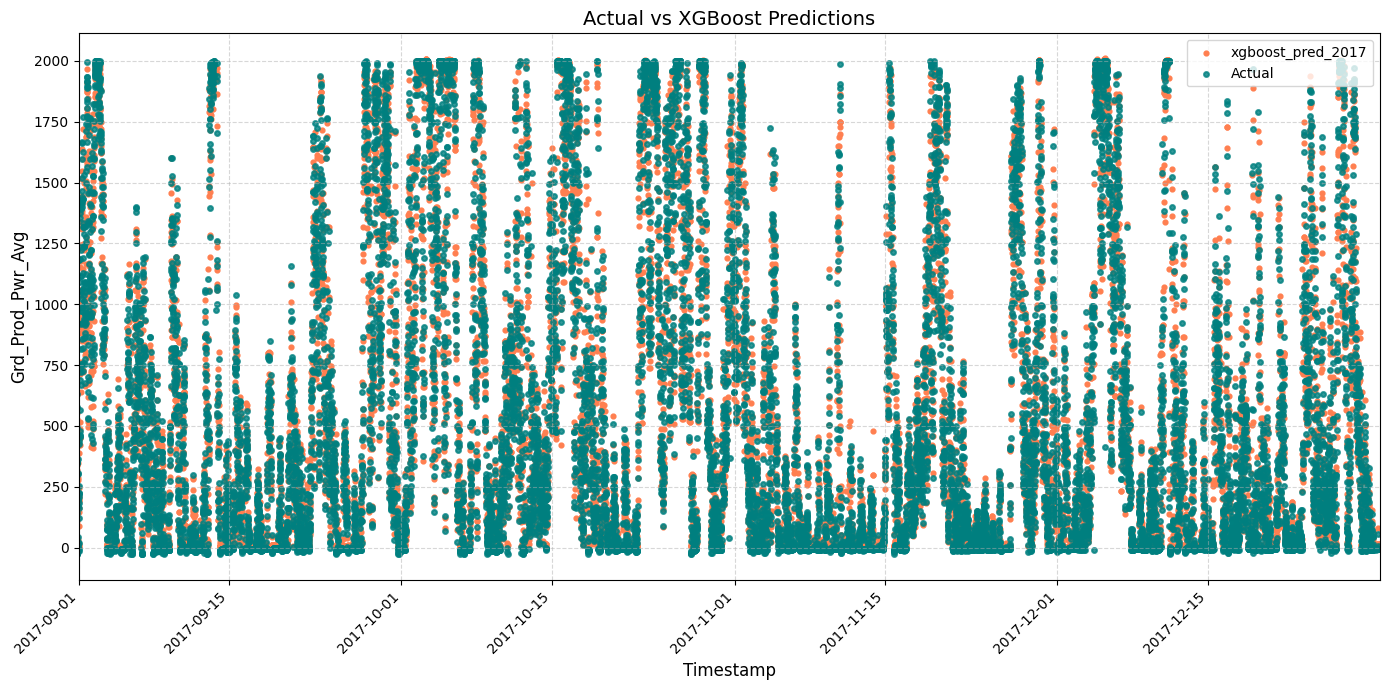

In [343]:
# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Start plotting
plt.figure(figsize=(14, 7))

# Scatter plot for xgboost predictions
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_pred_2017"],
    color='coral', marker='o', s=12, label='xgboost_pred_2017'
)

# Line plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, s=12,label='Actual', linestyle='-', linewidth=1.5
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-09-01'), pd.to_datetime('2017-12-31'))
plt.title("Actual vs XGBoost Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Intervals:

## Interval air density combinations

In [344]:
import pandas as pd
import numpy as np
import itertools

# Define intervals for the specific features
Humidity_interval = [-2, 2]       # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]          # hPa (for Avg_Pressure)
Amb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)

# Generate all combinations of interval adjustments
combinations_airdensity = list(itertools.product(
    Humidity_interval,
    Pressure_interval,
    Amb_Temp_interval
))

# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  # Dry air
R_v = 461.495  # Water vapor

# Iterate through the combinations
for idx, combo in enumerate(combinations_airdensity):
    Humidity_val, Pressure_val, Temp_val = combo
    
    # Apply interval adjustments to create new columns for each combination
    merged_df_filtered17_sorted[f'Avg_Humidity_{idx+1}'] = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val
    merged_df_filtered17_sorted[f'Avg_Pressure_{idx+1}'] = merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + Temp_val
    
    # Convert temperature to Kelvin and pressure to Pascals
    T = merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'] + 273.15  # Kelvin
    p = merged_df_filtered17_sorted[f'Avg_Pressure_{idx+1}'] * 100      # Pa
    
    # Calculate saturation vapor pressure (Pa) using the Magnus formula
    e_s = 6.112 * np.exp((17.67 * merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}']) / 
                          (merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'] + 243.5)) * 100
    
    # Convert relative humidity to a fraction
    RH_frac = merged_df_filtered17_sorted[f'Avg_Humidity_{idx+1}'] / 100.0
    
    # Calculate the actual water vapor pressure (Pa)
    p_v = RH_frac * e_s
    
    # Calculate the partial pressure of dry air (Pa)
    p_d = p - p_v
    
    # Compute air density (kg/m^3)
    merged_df_filtered17_sorted[f'airdensity_{idx+1}'] = (p_d / (R_d * T)) + (p_v / (R_v * T))
    
    # Print sample values for debugging
    print(f"\nCombination {idx+1}:")
    print("Avg_Humidity sample values:", merged_df_filtered17_sorted[f'Avg_Humidity_{idx+1}'].head(3).values)
    print("Avg_Pressure sample values:", merged_df_filtered17_sorted[f'Avg_Pressure_{idx+1}'].head(3).values)
    print("Amb_Temp_Avg sample values:", merged_df_filtered17_sorted[f'Amb_Temp_Avg_{idx+1}'].head(3).values)
    print("Calculated air density sample values:", merged_df_filtered17_sorted[f'airdensity_{idx+1}'].head(3).values)

# Optionally, save or visualize the modified DataFrame
# merged_df_filtered17_sorted.to_csv('airdensity_predictions.csv', index=False)



Combination 1:
Avg_Humidity sample values: [64 64 65]
Avg_Pressure sample values: [1019. 1019. 1019.]
Amb_Temp_Avg sample values: [12 12 12]
Calculated air density sample values: [1.24074847 1.24074847 1.24068375]

Combination 2:
Avg_Humidity sample values: [64 64 65]
Avg_Pressure sample values: [1019. 1019. 1019.]
Amb_Temp_Avg sample values: [16 16 16]
Calculated air density sample values: [1.22237374 1.22237374 1.222291  ]

Combination 3:
Avg_Humidity sample values: [64 64 65]
Avg_Pressure sample values: [1021. 1021. 1021.]
Amb_Temp_Avg sample values: [12 12 12]
Calculated air density sample values: [1.24319182 1.24319182 1.2431271 ]

Combination 4:
Avg_Humidity sample values: [64 64 65]
Avg_Pressure sample values: [1021. 1021. 1021.]
Amb_Temp_Avg sample values: [16 16 16]
Calculated air density sample values: [1.2247833  1.2247833  1.22470056]

Combination 5:
Avg_Humidity sample values: [68 68 69]
Avg_Pressure sample values: [1019. 1019. 1019.]
Amb_Temp_Avg sample values: [12 12 12

## Model for making air density with interval analysis
Inputs humidity, pressure and temp. Outputs all 8 combinations of air density for that timestep

In [345]:
# Define intervals for each feature
Amb_Temp_interval = [-2, 2]         # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-1, 1]          # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-1, 1]        # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-2, 2]     # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]         # hPa? (for Avg_Pressure)





In [346]:
"""
airdensity_interval = [max(merged_df_filtered17_sorted["air_density_interval"]), min(merged_df_filtered17_sorted["air_density_interval"])]
"""

'\nairdensity_interval = [max(merged_df_filtered17_sorted["air_density_interval"]), min(merged_df_filtered17_sorted["air_density_interval"])]\n'

In [347]:
"""# Calculate maximum values by adding the max of each interval to the average values
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(airdensity_interval)

# Calculate minimum values by adding the min of each interval to the average values
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(airdensity_interval)"""

'# Calculate maximum values by adding the max of each interval to the average values\nmerged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(airdensity_interval)\n\n# Calculate minimum values by adding the min of each interval to the average values\nmerged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(airdensity_interval)'

In [348]:
# Calculate maximum values by adding the max of each interval to the average values
##merged_df_filtered17_sorted["max_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + max(Amb_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
#merged_df_filtered17_sorted["max_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(Humidity_interval)
#merged_df_filtered17_sorted["max_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + max(Pressure_interval)


# Calculate minimum values by adding the min of each interval to the average values
#merged_df_filtered17_sorted["min_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] - min(Amb_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] - min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] - min(Windspeed_interval)
#merged_df_filtered17_sorted["min_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] - min(Humidity_interval)
#merged_df_filtered17_sorted["min_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] - min(Pressure_interval)

In [349]:
"""# Calculate maximum values by adding the max of each interval to the base air density
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(air_density_interval)

# Calculate minimum values by adding the min of each interval to the base air density
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(air_density_interval)
"""

'# Calculate maximum values by adding the max of each interval to the base air density\nmerged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density"] + max(air_density_interval)\n\n# Calculate minimum values by adding the min of each interval to the base air density\nmerged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density"] - min(air_density_interval)\n'

In [350]:
"""import pandas as pd
import numpy as np
import itertools

# Define intervals for the specific features
Humidity_interval = [-0.5, 0.5]       # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]          # hPa (for Avg_Pressure)
Amb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)

# Generate all combinations of interval adjustments
combinations_airdensity = list(itertools.product(
    Humidity_interval,
    Pressure_interval,
    Amb_Temp_interval
))

# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  # Dry air
R_v = 461.495  # Water vapor

# Create a column to store air density values for each timestep as a list
merged_df_filtered17_sorted["air_density_interval"] = [[] for _ in range(len(merged_df_filtered17_sorted))]

# Iterate through the combinations
for idx, (Humidity_val, Pressure_val, Temp_val) in enumerate(combinations_airdensity):
    
    # Apply interval adjustments
    adj_humidity = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val
    adj_pressure = merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    adj_temp = merged_df_filtered17_sorted["Amb_Temp_Avg"] + Temp_val

    # Convert temperature to Kelvin and pressure to Pascals
    T = adj_temp + 273.15  # Kelvin
    p = adj_pressure * 100  # Pa

    # Calculate saturation vapor pressure (Pa) using the Magnus formula
    e_s = 6.112 * np.exp((17.67 * adj_temp) / (adj_temp + 243.5)) * 100

    # Convert relative humidity to a fraction
    RH_frac = adj_humidity / 100.0

    # Calculate the actual water vapor pressure (Pa)
    p_v = RH_frac * e_s

    # Calculate the partial pressure of dry air (Pa)
    p_d = p - p_v

    # Compute air density (kg/m^3)
    air_density = (p_d / (R_d * T)) + (p_v / (R_v * T))

    # Store in DataFrame
    merged_df_filtered17_sorted[f'airdensity_{idx+1}'] = air_density
    merged_df_filtered17_sorted["air_density_interval"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: list(x) + [air_density.tolist()])

# Compute max and min air density
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: max(np.concatenate(x)))
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: min(np.concatenate(x)))
"""

'import pandas as pd\nimport numpy as np\nimport itertools\n\n# Define intervals for the specific features\nHumidity_interval = [-0.5, 0.5]       # percentage (for Avg_Humidity)\nPressure_interval = [-1, 1]          # hPa (for Avg_Pressure)\nAmb_Temp_interval = [-2, 2]          # Celsius (for Amb_Temp_Avg)\n\n# Generate all combinations of interval adjustments\ncombinations_airdensity = list(itertools.product(\n    Humidity_interval,\n    Pressure_interval,\n    Amb_Temp_interval\n))\n\n# Define gas constants for dry air and water vapor in J/(kg*K)\nR_d = 287.058  # Dry air\nR_v = 461.495  # Water vapor\n\n# Create a column to store air density values for each timestep as a list\nmerged_df_filtered17_sorted["air_density_interval"] = [[] for _ in range(len(merged_df_filtered17_sorted))]\n\n# Iterate through the combinations\nfor idx, (Humidity_val, Pressure_val, Temp_val) in enumerate(combinations_airdensity):\n    \n    # Apply interval adjustments\n    adj_humidity = merged_df_filtere

In [351]:
import pandas as pd
import numpy as np
import itertools

# Define intervals for the specific features
Humidity_interval = [-0.3, 0.3]       # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]          # hPa (for Avg_Pressure)
Amb_Temp_interval = [-1, 1]          # Celsius (for Amb_Temp_Avg)

# Generate all combinations of interval adjustments
combinations_airdensity = list(itertools.product(
    Humidity_interval,
    Pressure_interval,
    Amb_Temp_interval
))

# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  # Dry air
R_v = 461.495  # Water vapor

# Initialize a dictionary to store air density values for each timestep
air_density_values = {idx: [] for idx in range(len(merged_df_filtered17_sorted))}

# Iterate through the combinations
for Humidity_val, Pressure_val, Temp_val in combinations_airdensity:
    
    # Apply interval adjustments
    adj_humidity = merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val
    adj_pressure = merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
    adj_temp = merged_df_filtered17_sorted["Amb_Temp_Avg"] + Temp_val

    # Convert temperature to Kelvin and pressure to Pascals
    T = adj_temp + 273.15  # Kelvin
    p = adj_pressure * 100  # Pa

    # Calculate saturation vapor pressure (Pa) using the Magnus formula
    e_s = 6.112 * np.exp((17.67 * adj_temp) / (adj_temp + 243.5)) * 100

    # Convert relative humidity to a fraction
    RH_frac = adj_humidity / 100.0

    # Calculate the actual water vapor pressure (Pa)
    p_v = RH_frac * e_s

    # Calculate the partial pressure of dry air (Pa)
    p_d = p - p_v

    # Compute air density (kg/m^3)
    air_density = (p_d / (R_d * T)) + (p_v / (R_v * T))

    # Store air density values in the dictionary
    for idx, value in enumerate(air_density):
        air_density_values[idx].append(value)

# Ensure values are lists before assignment
merged_df_filtered17_sorted["air_density_interval"] = merged_df_filtered17_sorted.index.map(lambda x: air_density_values.get(x, []))

# Compute max and min air density safely
merged_df_filtered17_sorted["max_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: max(x) if x else np.nan)
merged_df_filtered17_sorted["min_air_density"] = merged_df_filtered17_sorted["air_density_interval"].apply(lambda x: min(x) if x else np.nan)


In [352]:
"""import itertools
import pandas as pd
import numpy as np

# Define additional feature intervals
Gen_RPM_interval = [-50, 50]         # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-1, 1]         # m/s (for Amb_WindSpeed_Avg)

# Generate all 8 combinations of max/min values
combinations = list(itertools.product(["max", "min"], ["max", "min"], ["max", "min"]))

# Compute max/min for Wind Speed and Generator RPM
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + min(Windspeed_interval)

# Iterate through all 8 combinations
for idx, (air_density_key, wind_speed_key, rpm_key) in enumerate(combinations):
    
    # Ensure correct column names for air density
    air_density_col = f"{air_density_key}_air_density"
    
    if air_density_col not in merged_df_filtered17_sorted.columns:
        print(f"Warning: {air_density_col} not found in DataFrame. Skipping combination {idx+1}.")
        continue

    # Create X_test for each combination
    X_test = pd.DataFrame({
        'Gen_RPM_Avg': merged_df_filtered17_sorted[f"{rpm_key}_Gen_RPM_Avg"],
        'Amb_WindSpeed_Avg': merged_df_filtered17_sorted[f"{wind_speed_key}_Amb_WindSpeed_Avg"],
        "air_density": merged_df_filtered17_sorted[air_density_col]
    })

    # Handle potential NaN values before prediction
    X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values

    # Predict power output
    predictions = model.predict(X_test)

    # Store results
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions
    print(f"Combination {idx+1} done: air_density={air_density_key}, wind_speed={wind_speed_key}, rpm={rpm_key}")
"""

'import itertools\nimport pandas as pd\nimport numpy as np\n\n# Define additional feature intervals\nGen_RPM_interval = [-50, 50]         # RPM (for Gen_RPM_Avg)\nWindspeed_interval = [-1, 1]         # m/s (for Amb_WindSpeed_Avg)\n\n# Generate all 8 combinations of max/min values\ncombinations = list(itertools.product(["max", "min"], ["max", "min"], ["max", "min"]))\n\n# Compute max/min for Wind Speed and Generator RPM\nmerged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)\nmerged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)\nmerged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)\nmerged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + min(Windspeed_interval)\n\n# Iterate through all 8 combinations\nfor idx, (air_density_key, wind_speed_ke

In [353]:
import itertools
import pandas as pd
import numpy as np

# Create X_test ensuring column order matches model training
X_test = merged_df_filtered17_sorted[["airdensity", "Amb_WindSpeed_Avg"]]

# Define additional feature intervals
Gen_RPM_interval = [-2, 2]         # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-0.3, 0.3]         # m/s (for Amb_WindSpeed_Avg)

# Generate all 8 combinations of max/min values
combinations = list(itertools.product(["max", "min"], ["max", "min"], ["max", "min"]))

# Compute max/min for Wind Speed and Generator RPM
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + min(Windspeed_interval)

# Iterate through all 8 combinations
for idx, (air_density_key, wind_speed_key, rpm_key) in enumerate(combinations):
    
    # Ensure correct column names for air density
    air_density_col = f"{air_density_key}_air_density"
    
    if air_density_col not in merged_df_filtered17_sorted.columns:
        print(f"Warning: {air_density_col} not found in DataFrame. Skipping combination {idx+1}.")
        continue

    # Create X_test for each combination (ensuring column names match model)
    X_test = pd.DataFrame({
        "airdensity": merged_df_filtered17_sorted[air_density_col],
        'Amb_WindSpeed_Avg': merged_df_filtered17_sorted[f"{wind_speed_key}_Amb_WindSpeed_Avg"]
        
    })

    # Handle potential NaN values before prediction
    X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values

    # Predict power output using the trained model
    predictions = model.predict(X_test)

    # Store results in DataFrame
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions
    print(f"Combination {idx+1} done: air_density={air_density_key}, wind_speed={wind_speed_key}, rpm={rpm_key}")


Combination 1 done: air_density=max, wind_speed=max, rpm=max
Combination 2 done: air_density=max, wind_speed=max, rpm=min
Combination 3 done: air_density=max, wind_speed=min, rpm=max
Combination 4 done: air_density=max, wind_speed=min, rpm=min
Combination 5 done: air_density=min, wind_speed=max, rpm=max
Combination 6 done: air_density=min, wind_speed=max, rpm=min
Combination 7 done: air_density=min, wind_speed=min, rpm=max
Combination 8 done: air_density=min, wind_speed=min, rpm=min


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3209766536.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3209766536.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3209766536.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test.fillna(method="ffill", inplace=True)  # Forward fill NaN values
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3209766536.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use o

In [354]:
print(model.get_booster().feature_names)

['airdensity', 'Amb_WindSpeed_Avg']


In [355]:
"""# Define min/max column names
min_columns = ["min_air_density",  "min_Amb_WindSpeed_Avg"]
max_columns = ["max_air_density",  "max_Amb_WindSpeed_Avg"]


# Generate all 32 combinations of 'min' and 'max' features
combinations = []
for i in range(32):
    combination = [max_columns[j] if (i >> j) & 1 else min_columns[j] for j in range(5)]
    combinations.append(combination)


# Ensure correct feature order for predictions
feature_columns = ["air_density", "Amb_WindSpeed_Avg"]

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    try:
        # Prepare feature set for the current combination
        combination_features = merged_df_filtered17_sorted[comb].copy()

        # Rename columns to match model feature order
        combination_features.columns = feature_columns

        # Ensure proper column order
        combination_features = combination_features[feature_columns]

        # Generate predictions
        predictions = model.predict(combination_features)

        # Add predictions to DataFrame
        merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

    except KeyError as e:
        print(f"KeyError in combination {idx}: {e}. Skipping this combination.")
    except Exception as e:
        print(f"Unexpected error in combination {idx}: {e}")


# Print first few rows to verify
print(merged_df_filtered17_sorted.head())
"""

'# Define min/max column names\nmin_columns = ["min_air_density",  "min_Amb_WindSpeed_Avg"]\nmax_columns = ["max_air_density",  "max_Amb_WindSpeed_Avg"]\n\n\n# Generate all 32 combinations of \'min\' and \'max\' features\ncombinations = []\nfor i in range(32):\n    combination = [max_columns[j] if (i >> j) & 1 else min_columns[j] for j in range(5)]\n    combinations.append(combination)\n\n\n# Ensure correct feature order for predictions\nfeature_columns = ["air_density", "Amb_WindSpeed_Avg"]\n\n# Predict for each combination\nfor idx, comb in enumerate(combinations, 1):\n    try:\n        # Prepare feature set for the current combination\n        combination_features = merged_df_filtered17_sorted[comb].copy()\n\n        # Rename columns to match model feature order\n        combination_features.columns = feature_columns\n\n        # Ensure proper column order\n        combination_features = combination_features[feature_columns]\n\n        # Generate predictions\n        predictions = m

In [356]:

print(merged_df_filtered17_sorted.iloc[0])


Turbine_ID                           T07
Timestamp      2017-01-01 00:00:00+00:00
Gen_RPM_Max                       1513.4
Gen_RPM_Min                       1255.3
Gen_RPM_Avg                       1336.5
                         ...            
pred_comb_4                   320.264801
pred_comb_5                   434.495789
pred_comb_6                   434.495789
pred_comb_7                   320.264801
pred_comb_8                   320.264801
Name: 52211, Length: 174, dtype: object


In [357]:
Arotor

6362

## Only sensor error:

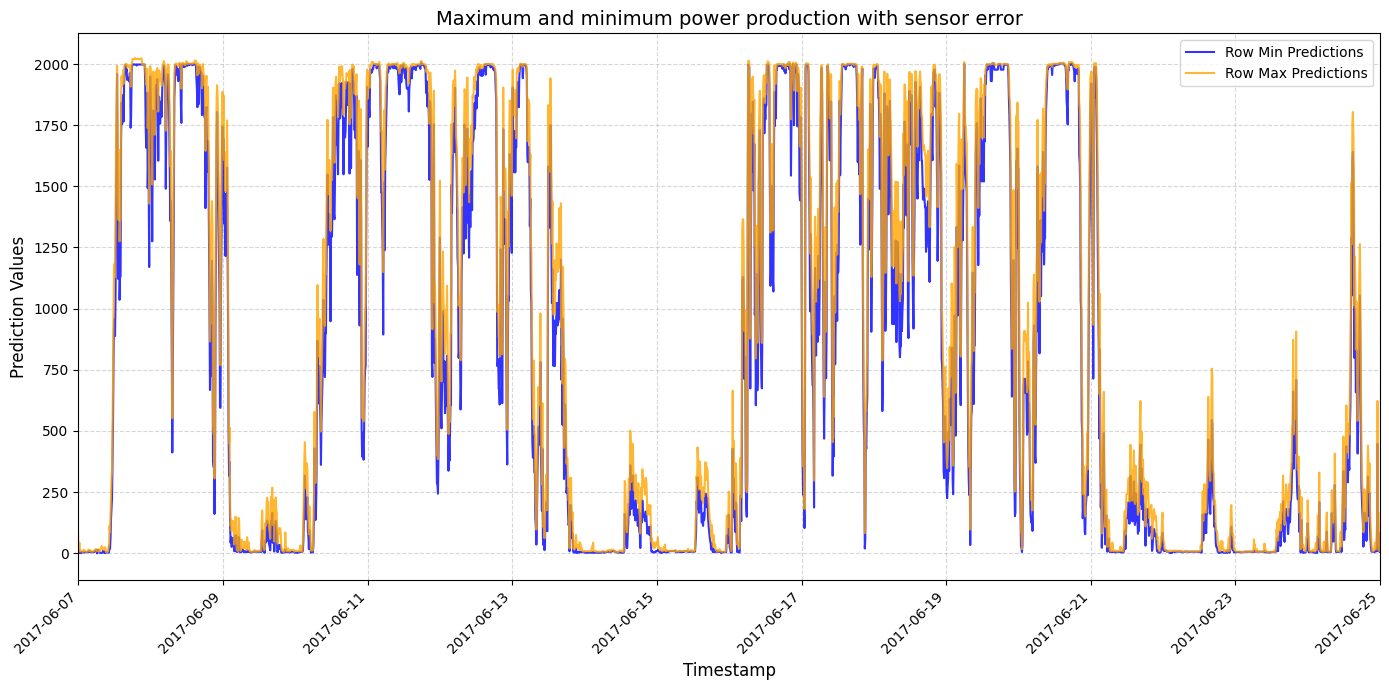

In [358]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Maximum and minimum power production with sensor error", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Prediction Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


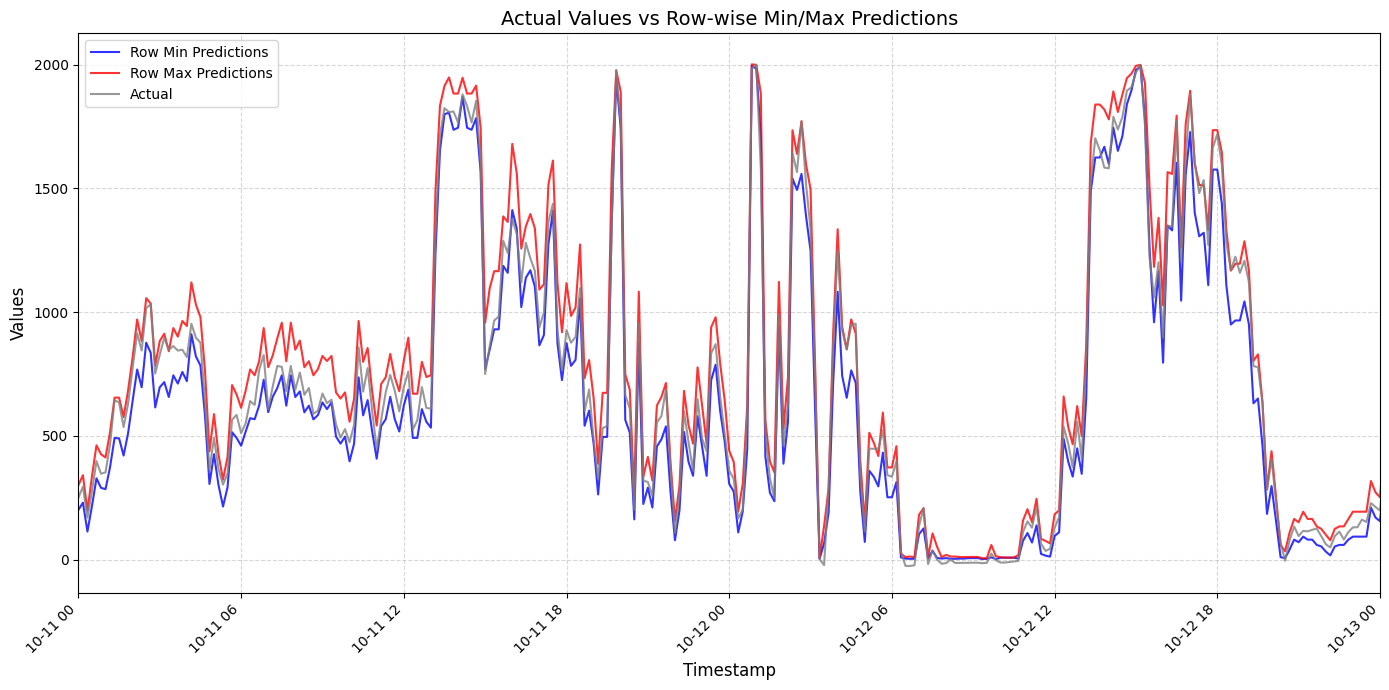

In [359]:


# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-10-11'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


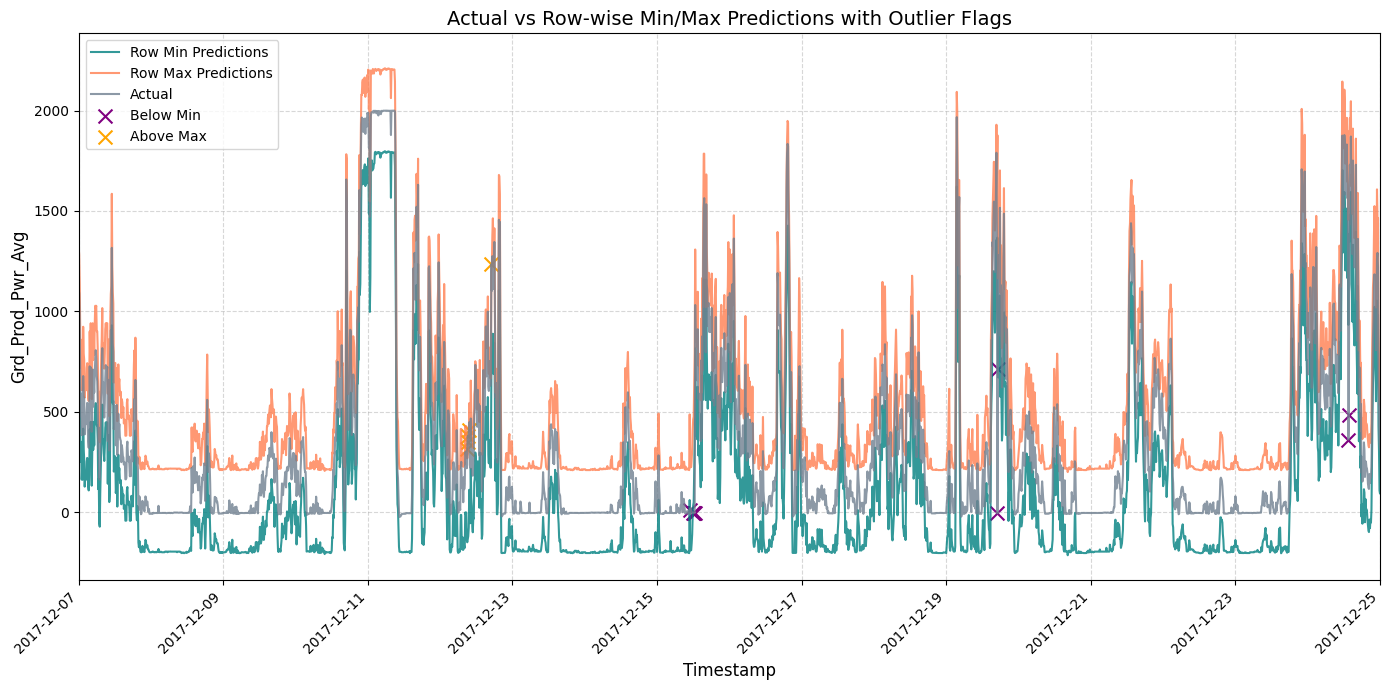

In [360]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Calculate deviation from actual prediction, then apply RSS with modelling error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - np.sqrt((merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + modelling_error_xgboost**2)

merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + np.sqrt((merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + modelling_error_xgboost**2)


# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)



# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='teal', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='coral', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='slategrey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Adjust maximum power production here:

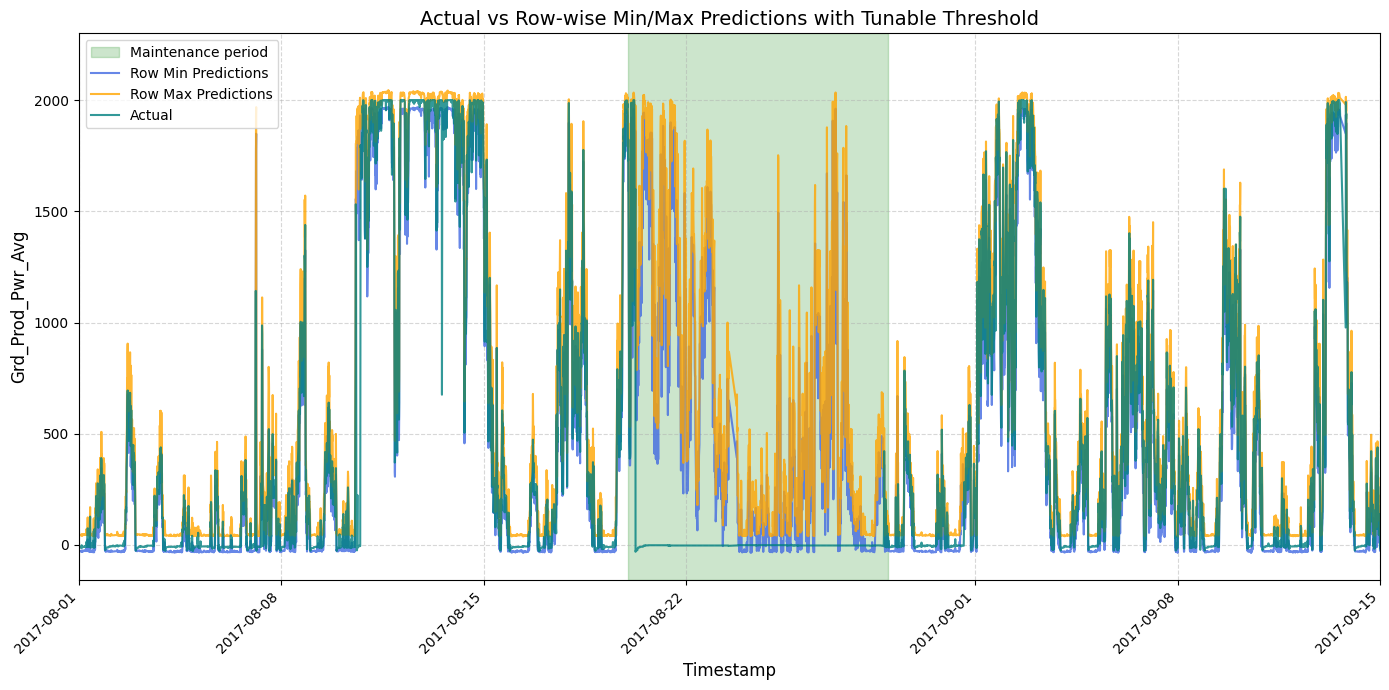

In [361]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Calculate deviation from actual prediction, then apply RSS with modelling error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - np.sqrt((merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + modelling_error_xgboost_inference**2)

merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + np.sqrt((merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + modelling_error_xgboost_inference**2)


# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"])
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"])
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] , 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] , 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

"""# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='coral', marker='x', s=50, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {threshold}'
)"""

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2017-09-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


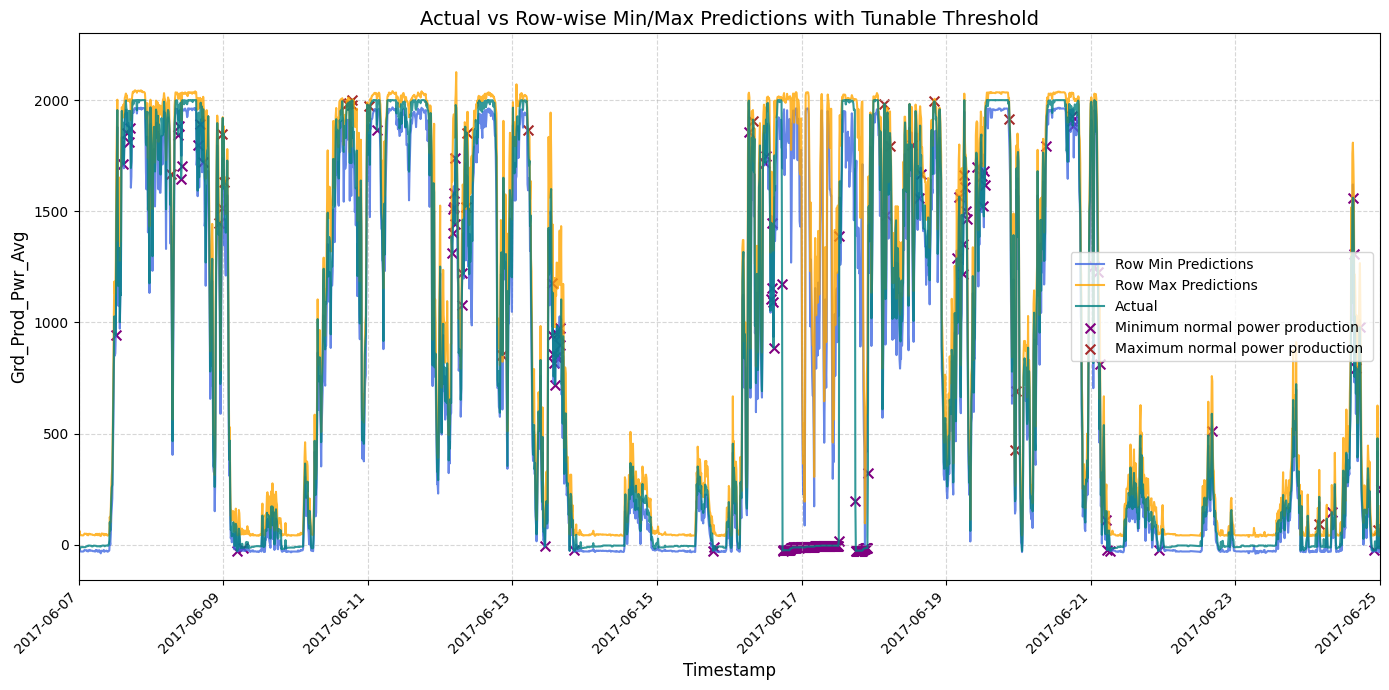

In [362]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')


# Calculate deviation from actual prediction, then apply RSS with modelling error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - np.sqrt((merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + modelling_error_xgboost_inference**2)

merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + np.sqrt((merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + modelling_error_xgboost_inference**2)




# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"])
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"])
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=50, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production '
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


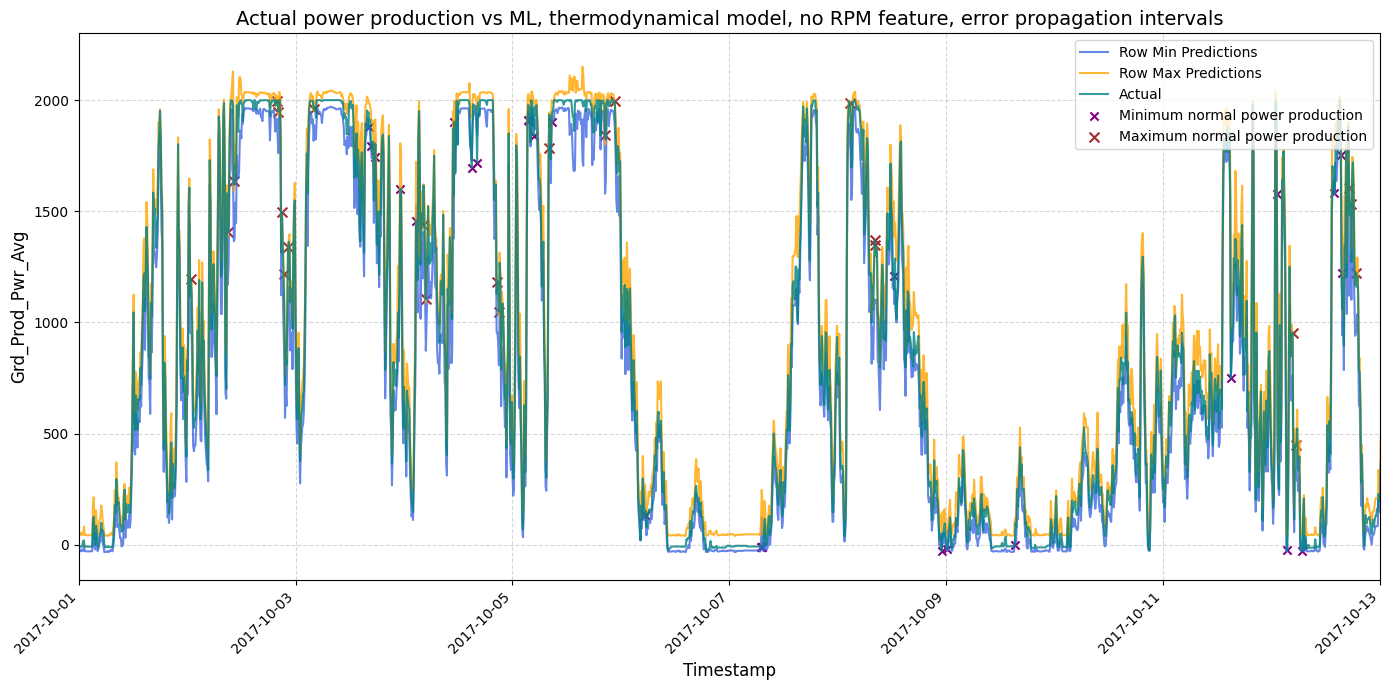

In [363]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')


# Calculate deviation from actual prediction, then apply RSS with modelling error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - np.sqrt((merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + modelling_error_xgboost_inference**2)

merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + np.sqrt((merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + modelling_error_xgboost_inference**2)



# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] )
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] )
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] , 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))


# Title and labels
plt.title("Actual power production vs ML, thermodynamical model, no RPM feature, error propagation intervals", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


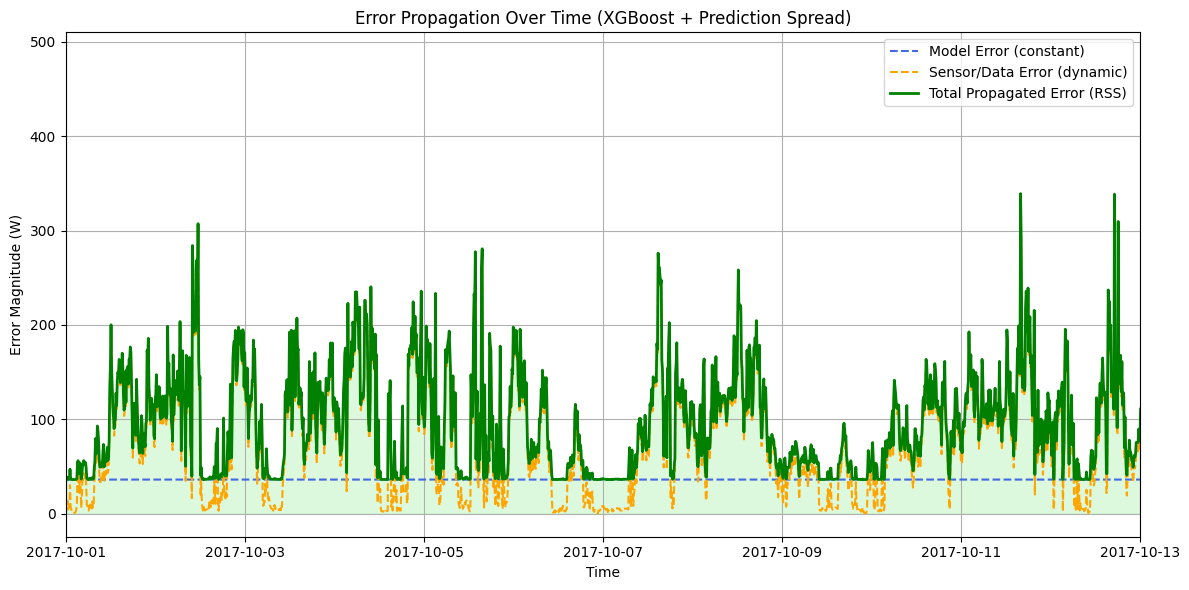

In [364]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define individual errors from your setup ---
# Constant model error (same for all rows)
model_error = np.full(len(merged_df_filtered17_sorted), modelling_error_xgboost_inference)

# Dynamic sensor/data error — use the spread from ensemble models
sensor_error = np.where(
    merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"] >
    merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1),
    merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"],
    merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1)
)

# Propagated error using root-sum-square (RSS)
combined_error = np.sqrt(sensor_error**2 + model_error**2)

# Time values
timestamps = merged_df_filtered17_sorted["Timestamp"]

# --- Plot ---
plt.figure(figsize=(12, 6))

plt.plot(timestamps, model_error, label='Model Error (constant)', linestyle='--', color='royalblue')
plt.plot(timestamps, sensor_error, label='Sensor/Data Error (dynamic)', linestyle='--', color='orange')
plt.plot(timestamps, combined_error, label='Total Propagated Error (RSS)', linewidth=2, color='green')

plt.fill_between(timestamps, 0, combined_error, color='lightgreen', alpha=0.3)

plt.xlabel("Time")
plt.ylabel("Error Magnitude (W)")
plt.title("Error Propagation Over Time (XGBoost + Prediction Spread)")
plt.legend()
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))
plt.grid(True)
plt.tight_layout()
plt.show()




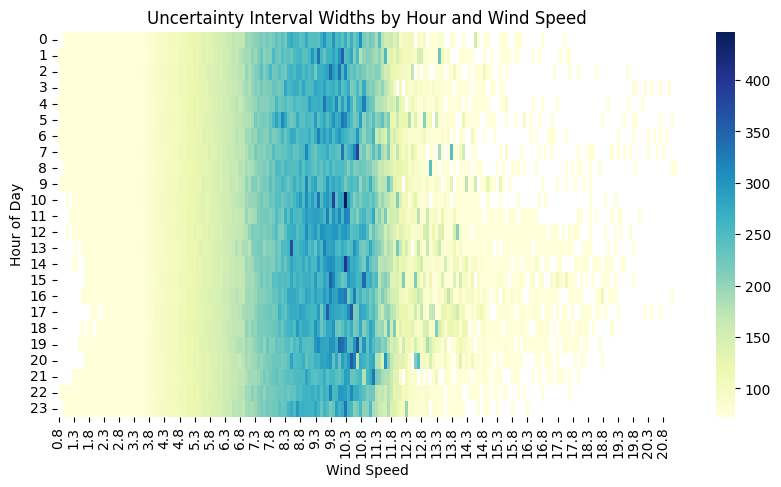

In [365]:
import seaborn as sns

merged_df_filtered17_sorted['interval_width'] = merged_df_filtered17_sorted["row_max"] - merged_df_filtered17_sorted["row_min"]

# Example heatmap by hour of day vs wind speed
merged_df_filtered17_sorted['hour'] = merged_df_filtered17_sorted['Timestamp'].dt.hour
sns.heatmap(
    merged_df_filtered17_sorted.pivot_table(
        index='hour', 
        columns="max_Amb_WindSpeed_Avg",  # replace with actual wind speed col
        values='interval_width', 
        aggfunc='mean'
    ),
    cmap="YlGnBu"
)

plt.title("Uncertainty Interval Widths by Hour and Wind Speed")
plt.xlabel("Wind Speed")
plt.ylabel("Hour of Day")
plt.show()


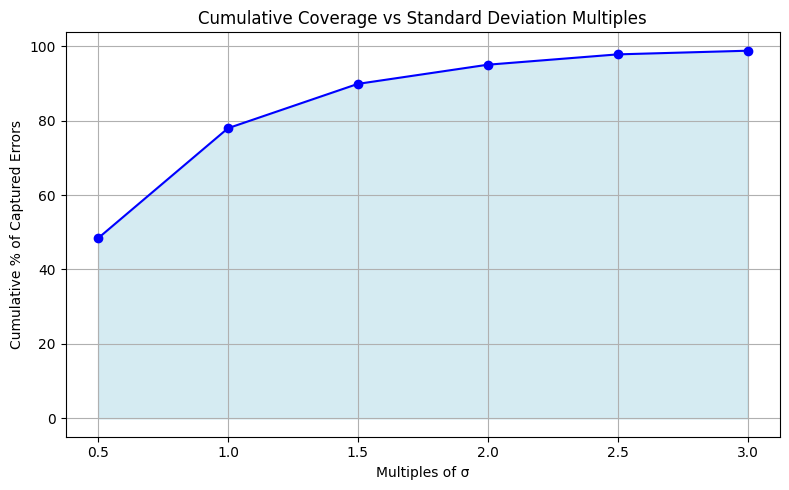

In [366]:
plt.figure(figsize=(8, 5))
plt.plot(multiples_of_sigma, coverage_percentages, marker='o', linestyle='-', color='blue')
plt.fill_between(multiples_of_sigma, coverage_percentages, color='lightblue', alpha=0.5)

plt.xlabel("Multiples of σ")
plt.ylabel("Cumulative % of Captured Errors")
plt.title("Cumulative Coverage vs Standard Deviation Multiples")
plt.grid(True)
plt.tight_layout()
plt.show()


Correlation matrix between spread error and model error:
              spread_error  model_error
spread_error           1.0          NaN
model_error            NaN          NaN


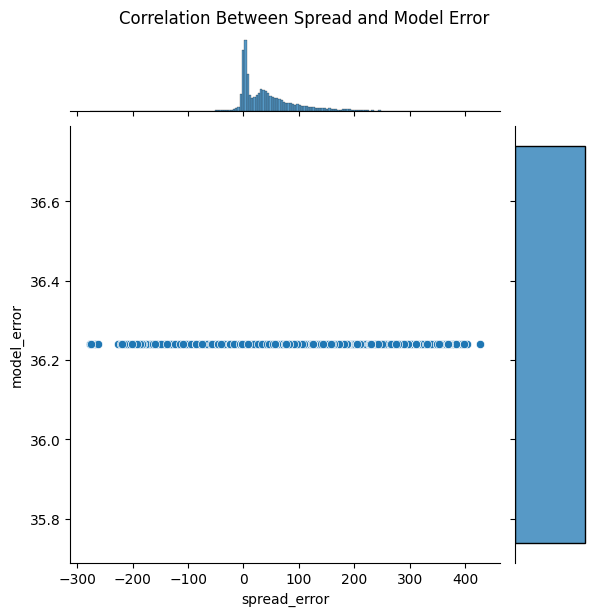

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Difference between XGBoost and min of prediction columns
spread = merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1)

# We assume modelling_error_xgboost_inference is a constant
model_error_component = np.full_like(spread, modelling_error_xgboost_inference)

# Combine into a DataFrame for correlation analysis
error_df = pd.DataFrame({
    "spread_error": spread,
    "model_error": model_error_component
})

# Check correlation
correlation = error_df.corr()

print("Correlation matrix between spread error and model error:")
print(correlation)

# Visualize it
sns.jointplot(x="spread_error", y="model_error", data=error_df, kind="scatter")
plt.suptitle("Correlation Between Spread and Model Error", y=1.02)
plt.show()


In [368]:
"""import matplotlib.pyplot as plt
import pandas as pd

# === Visualization ===
plt.figure(figsize=(14, 7))

# Plot diff_max_actual with time
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["diff_max_actual"], 
    color='teal', label="diff_max_actual"
)

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Anomaly Threshold (0)")

# Configure plot
plt.title("Diff Max Actual Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Diff Max Actual", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-05-07'), pd.to_datetime('2017-12-25'))

# Show plot
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# === Visualization ===\nplt.figure(figsize=(14, 7))\n\n# Plot diff_max_actual with time\nplt.plot(\n    merged_df_filtered17_sorted["Timestamp"], \n    merged_df_filtered17_sorted["diff_max_actual"], \n    color=\'teal\', label="diff_max_actual"\n)\n\n# Add reference line for anomaly threshold\nplt.axhline(y=0, color=\'coral\', linestyle="--", label="Anomaly Threshold (0)")\n\n# Configure plot\nplt.title("Diff Max Actual Over Time", fontsize=14)\nplt.xlabel("Timestamp", fontsize=12)\nplt.ylabel("Diff Max Actual", fontsize=12)\nplt.legend(fontsize=10)\nplt.grid(True, linestyle=\'--\', alpha=0.5)\nplt.xticks(rotation=45, ha=\'right\')\nplt.tight_layout()\n\n# Apply x-axis limits\nplt.xlim(pd.to_datetime(\'2017-05-07\'), pd.to_datetime(\'2017-12-25\'))\n\n# Show plot\nplt.show()\n'

In [369]:
"""# Plot the feature with Timestamp on the x-axis and apply x-axis limits for better visibility
plt.figure(figsize=(14, 7))
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['diff_max_actual'], label='diff_max_actual', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold (0)')
plt.title('Feature Plot with Anomalies Over Time')
plt.xlabel('Timestamp')
plt.ylabel('diff_max_actual')
plt.legend()
plt.grid()

# Limiting the x-axis to show a specific portion of the data for clarity
plt.xlim(merged_df_filtered17_sorted['Timestamp'].iloc[0], 
         merged_df_filtered17_sorted['Timestamp'].iloc[100])  # Example: first 100 points
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
"""

"# Plot the feature with Timestamp on the x-axis and apply x-axis limits for better visibility\nplt.figure(figsize=(14, 7))\nplt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['diff_max_actual'], label='diff_max_actual', color='blue')\nplt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold (0)')\nplt.title('Feature Plot with Anomalies Over Time')\nplt.xlabel('Timestamp')\nplt.ylabel('diff_max_actual')\nplt.legend()\nplt.grid()\n\n# Limiting the x-axis to show a specific portion of the data for clarity\nplt.xlim(merged_df_filtered17_sorted['Timestamp'].iloc[0], \n         merged_df_filtered17_sorted['Timestamp'].iloc[100])  # Example: first 100 points\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()\n"

In [370]:
# Filter the data by date range
date_filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= pd.to_datetime("2017-06-07").tz_localize("UTC")) &
    (merged_df_filtered17_sorted["Timestamp"] <= pd.to_datetime("2017-12-25").tz_localize("UTC"))
]
date_filtered_data.dropna(subset=["Gen_Bear_Temp_Avg", target_column, "Timestamp"])
# Use the smaller dataset for pairwise calculations
temperature_data = date_filtered_data["Gen_Bear_Temp_Avg"].values
actual = date_filtered_data["Gen_Bear_Temp_Avg"].values
predicted = date_filtered_data[target_column].values
timestamps = date_filtered_data["Timestamp"].values

Additional isolation forrest

# Without sensotivity analysis

(np.float64(17297.0), np.float64(17311.0))

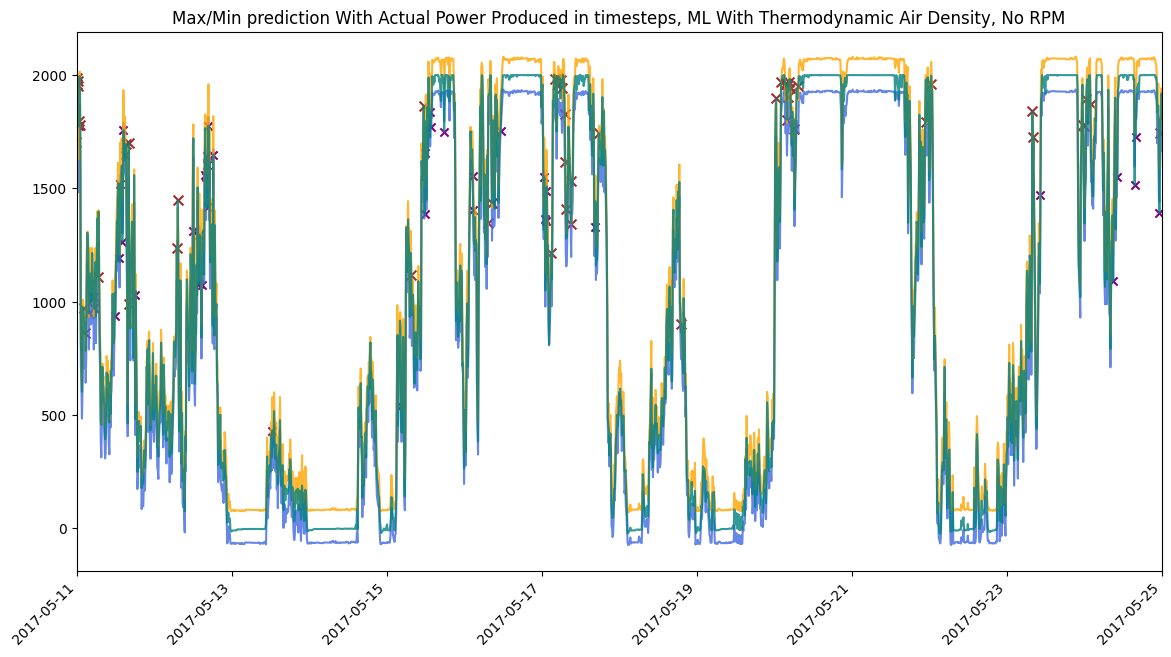

In [371]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define the XGBoost prediction column (without sensor variations)
xgboost_pred_column = "xgboost_pred_2017"

# Compute row-wise min and max **only based on modeling error**
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[xgboost_pred_column] - (modelling_error_xgboost_inference*2)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[xgboost_pred_column] + (modelling_error_xgboost_inference*2)

# Flag where actual values are outside the row-wise min and max with the threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Model Prediction Range'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Model Prediction Range'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.title("Max/Min prediction With Actual Power Produced in timesteps, ML With Thermodynamic Air Density, No RPM")
# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-5-11'), pd.to_datetime('2017-5-25'))

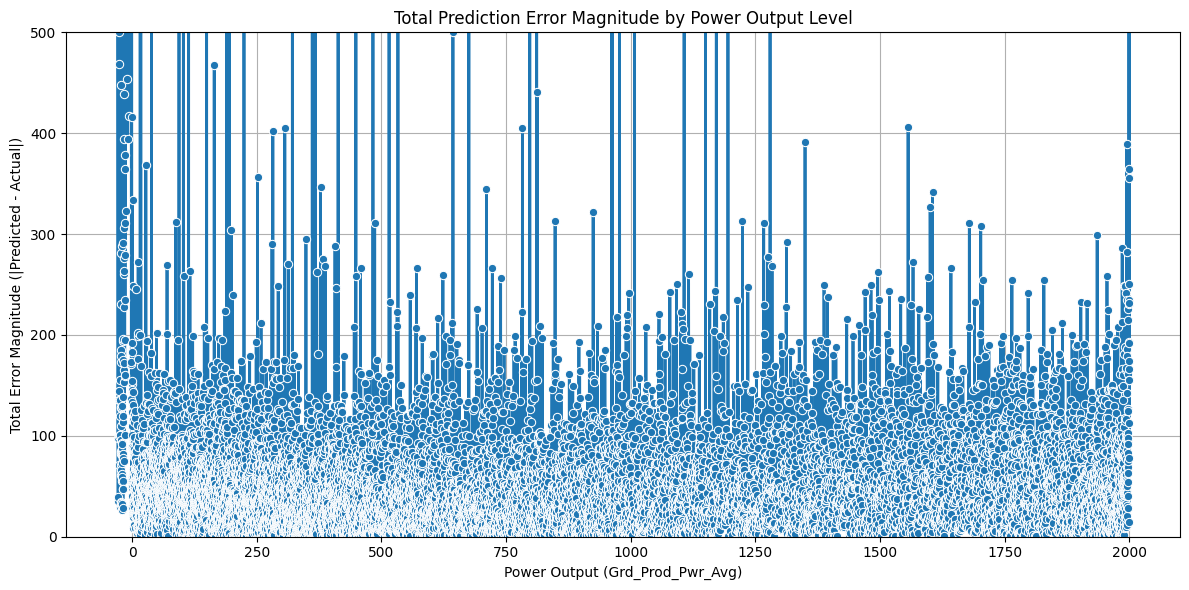

In [372]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors (difference between actual and predicted)
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Take absolute value of residuals to get error magnitude
merged_df_filtered17_sorted["abs_residual"] = merged_df_filtered17_sorted["residual"].abs()

# Group by power level and sum absolute residuals
error_magnitude_by_power = merged_df_filtered17_sorted.groupby(target_column)["abs_residual"].sum()

# Plot total error magnitude by power output
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_magnitude_by_power, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Total Error Magnitude (|Predicted - Actual|)")
plt.title("Total Prediction Error Magnitude by Power Output Level")
plt.grid(True)
plt.ylim(0,500)
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3076003342.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_magnitude_by_power_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].sum()


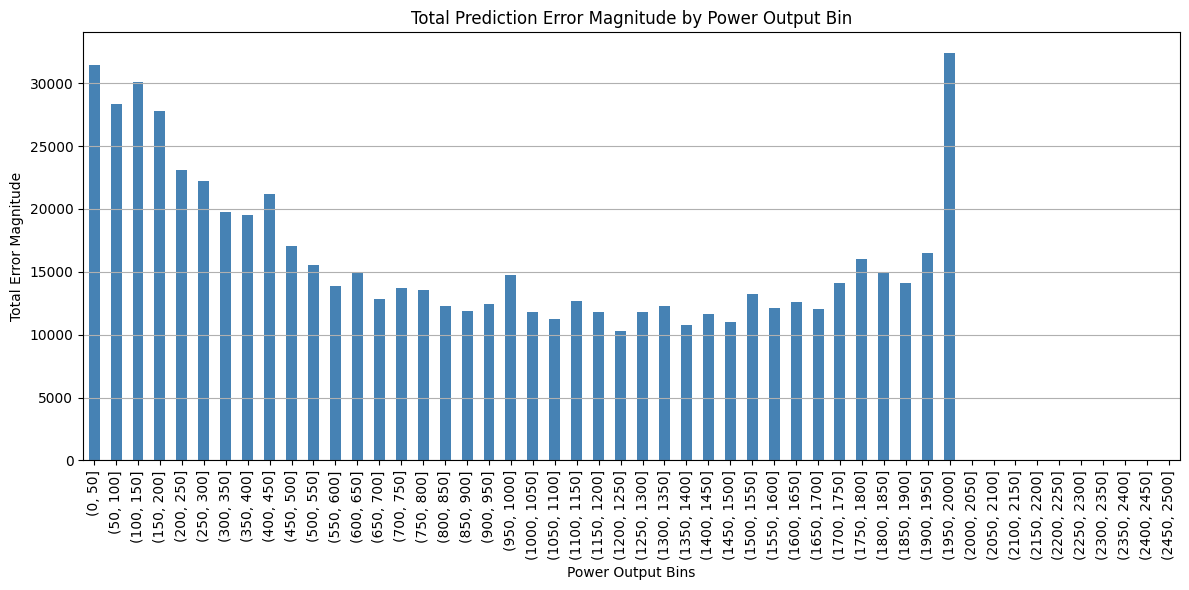

In [373]:
# Optional binning (e.g., 50 kW bins)
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=range(0, 2501, 50)
)

# Then group and plot as above
error_magnitude_by_power_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].sum()

plt.figure(figsize=(12, 6))
error_magnitude_by_power_bin.plot(kind='bar', color='steelblue')
plt.xlabel("Power Output Bins")
plt.ylabel("Total Error Magnitude")
plt.title("Total Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\2970831939.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_error_by_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].mean()


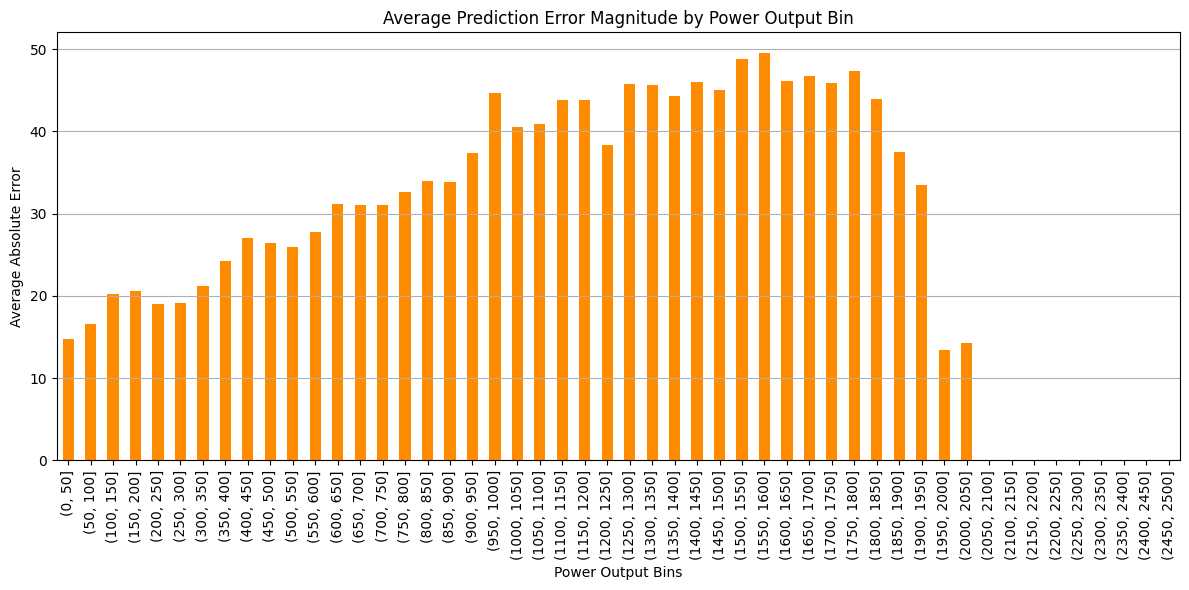

In [374]:
# Bin power output (e.g., 50 kW bins)
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=range(0, 2501, 50)
)

# Compute absolute residuals if not already done
merged_df_filtered17_sorted["abs_residual"] = (
    merged_df_filtered17_sorted["residual"].abs()
)

# Group by power bin and calculate mean error
avg_error_by_bin = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].mean()

# Plot
plt.figure(figsize=(12, 6))
avg_error_by_bin.plot(kind='bar', color='darkorange')
plt.xlabel("Power Output Bins")
plt.ylabel("Average Absolute Error")
plt.title("Average Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


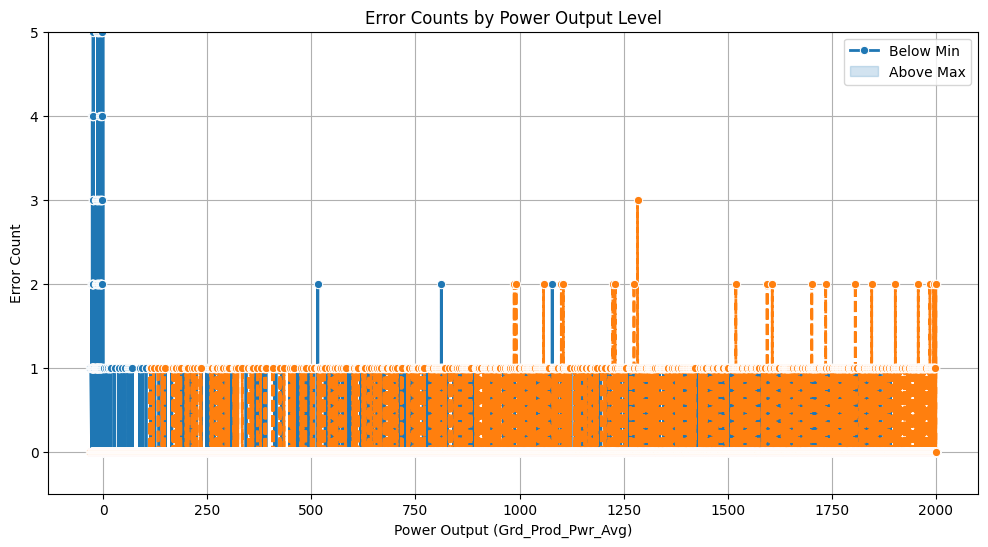

In [375]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Count errors (above_max and below_min) by power level
error_counts = merged_df_filtered17_sorted.groupby(target_column)[["below_min", "above_max"]].sum()

# Plot the error counts against power levels
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_counts, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Error Count")
plt.title("Error Counts by Power Output Level")
plt.legend(["Below Min", "Above Max"])
plt.grid(True)
plt.ylim(-0.5,5)
plt.show()


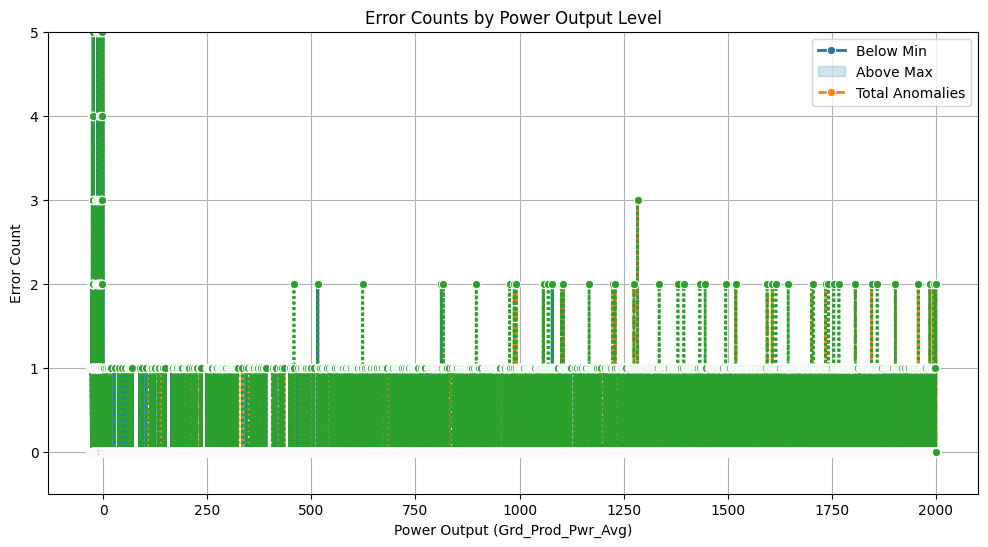

In [376]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Count errors (above_max and below_min) by power level
error_counts = merged_df_filtered17_sorted.groupby(target_column)[["below_min", "above_max"]].sum()

# Add a total anomalies column
error_counts["total_anomalies"] = error_counts["below_min"] + error_counts["above_max"]

# Plot the error counts against power levels
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_counts[["below_min", "above_max", "total_anomalies"]], marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Error Count")
plt.title("Error Counts by Power Output Level")
plt.legend(["Below Min", "Above Max", "Total Anomalies"])
plt.grid(True)
plt.ylim(-0.5,5)
plt.show()


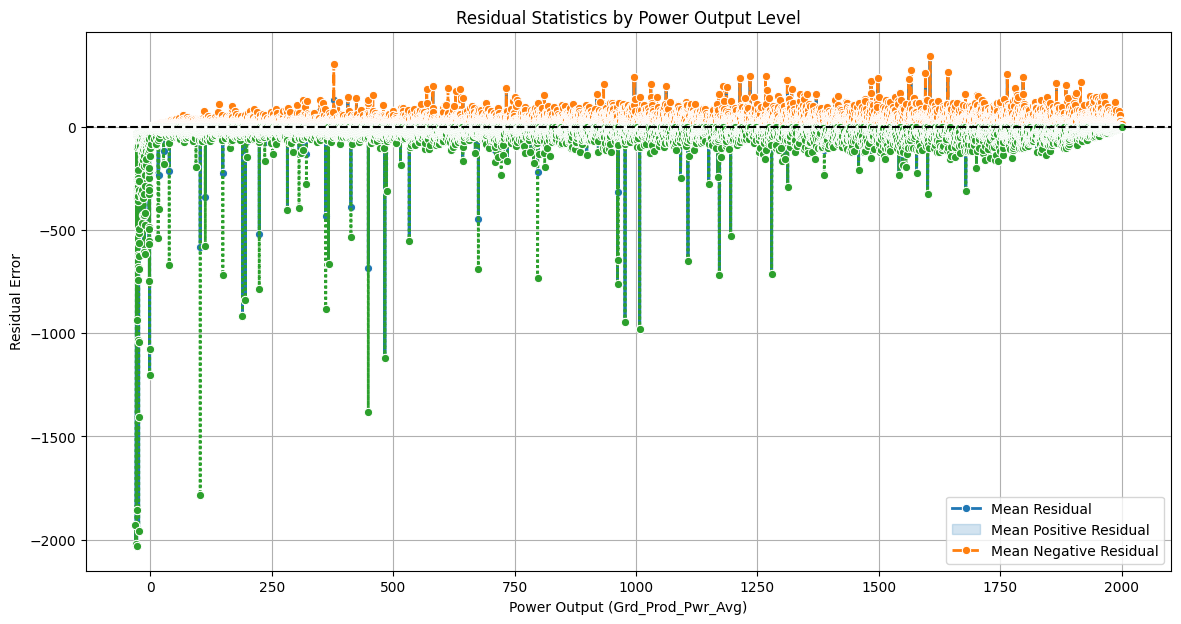

In [377]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Compute residual errors
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]
)

# Group by power output level and calculate residual statistics
residual_stats = merged_df_filtered17_sorted.groupby(target_column)["residual"].agg(
    mean_residual="mean",
    std_residual="std",
    count="count"
)

# (Optional) Separate positive and negative residuals
positive_residuals = merged_df_filtered17_sorted[merged_df_filtered17_sorted["residual"] > 0]
negative_residuals = merged_df_filtered17_sorted[merged_df_filtered17_sorted["residual"] < 0]

positive_stats = positive_residuals.groupby(target_column)["residual"].agg(mean_positive="mean")
negative_stats = negative_residuals.groupby(target_column)["residual"].agg(mean_negative="mean")

# Merge them into one dataframe
residual_stats = residual_stats.join(positive_stats).join(negative_stats)

# Plot the mean residual and standard deviation
plt.figure(figsize=(14, 7))
sns.lineplot(data=residual_stats[["mean_residual", "mean_positive", "mean_negative"]], marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Residual Error")
plt.title("Residual Statistics by Power Output Level")
plt.legend(["Mean Residual", "Mean Positive Residual", "Mean Negative Residual"])
plt.grid(True)
plt.axhline(0, color="black", linestyle="--")  # add a zero line
plt.show()


Now for inference testing

C:\Users\thors\AppData\Local\Temp\ipykernel_37340\1782418090.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_counts = merged_df_filtered17_sorted.groupby("power_bin")[["below_min", "above_max"]].sum()


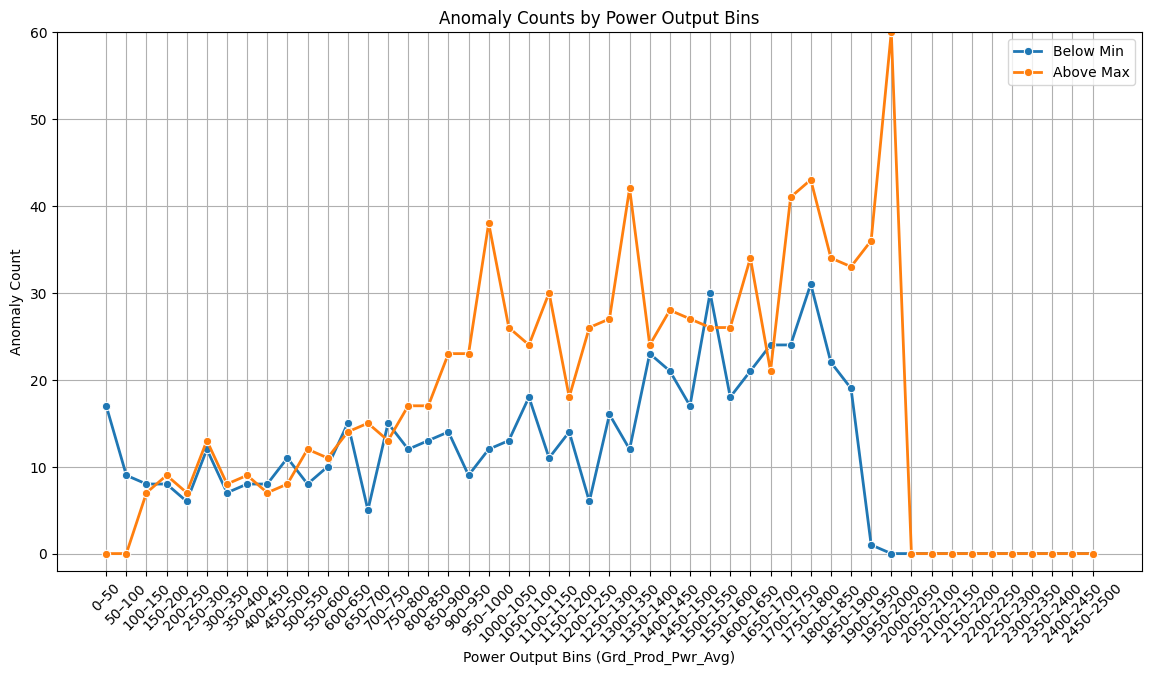

In [378]:
# Step 1: Reset the index
anomaly_counts = merged_df_filtered17_sorted.groupby("power_bin")[["below_min", "above_max"]].sum()


anomaly_counts_reset = anomaly_counts.reset_index()

# Step 2: Convert power_bin into string labels
anomaly_counts_reset["power_bin_str"] = anomaly_counts_reset["power_bin"].apply(lambda x: f"{int(x.left)}–{int(x.right)}")

# Step 3: Now plot using the new string labels
plt.figure(figsize=(14, 7))

sns.lineplot(
    x="power_bin_str", 
    y="below_min", 
    data=anomaly_counts_reset, 
    marker="o", 
    linewidth=2, 
    label="Below Min"
)
sns.lineplot(
    x="power_bin_str", 
    y="above_max", 
    data=anomaly_counts_reset, 
    marker="o", 
    linewidth=2, 
    label="Above Max"
)

plt.xlabel("Power Output Bins (Grd_Prod_Pwr_Avg)")
plt.ylabel("Anomaly Count")
plt.title("Anomaly Counts by Power Output Bins")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(-2, 60)
plt.show()


Lets check this for inference period

C:\Users\thors\AppData\Local\Temp\ipykernel_37340\4174206933.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["residual"] = (
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\4174206933.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["abs_residual"] = filtered_df["residual"].abs()


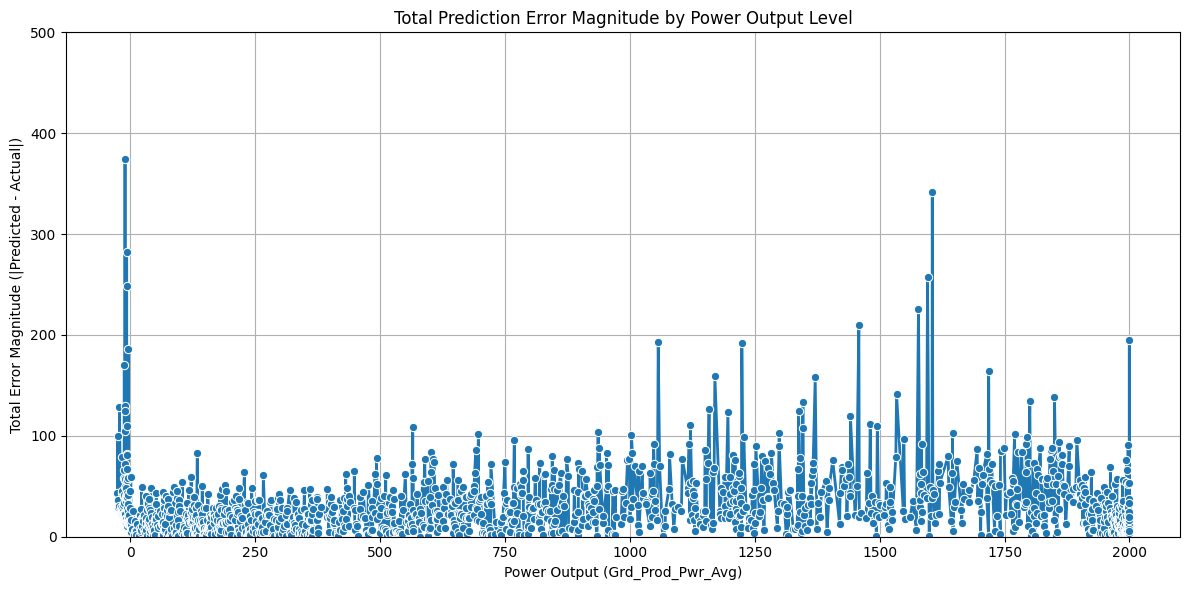

In [379]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors (difference between actual and predicted)
filtered_df["residual"] = (
    filtered_df[target_column] - filtered_df["xgboost_pred_2017"]
)

# Take absolute value of residuals to get error magnitude
filtered_df["abs_residual"] = filtered_df["residual"].abs()

# Group by power level and sum absolute residuals
error_magnitude_by_power = filtered_df.groupby(target_column)["abs_residual"].sum()

# Plot total error magnitude by power output
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_magnitude_by_power, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Total Error Magnitude (|Predicted - Actual|)")
plt.title("Total Prediction Error Magnitude by Power Output Level")
plt.grid(True)
plt.ylim(0,500)
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\920066315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["power_bin"] = pd.cut(
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\920066315.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_magnitude_by_power_bin = filtered_df.groupby("power_bin")["abs_residual"].sum()


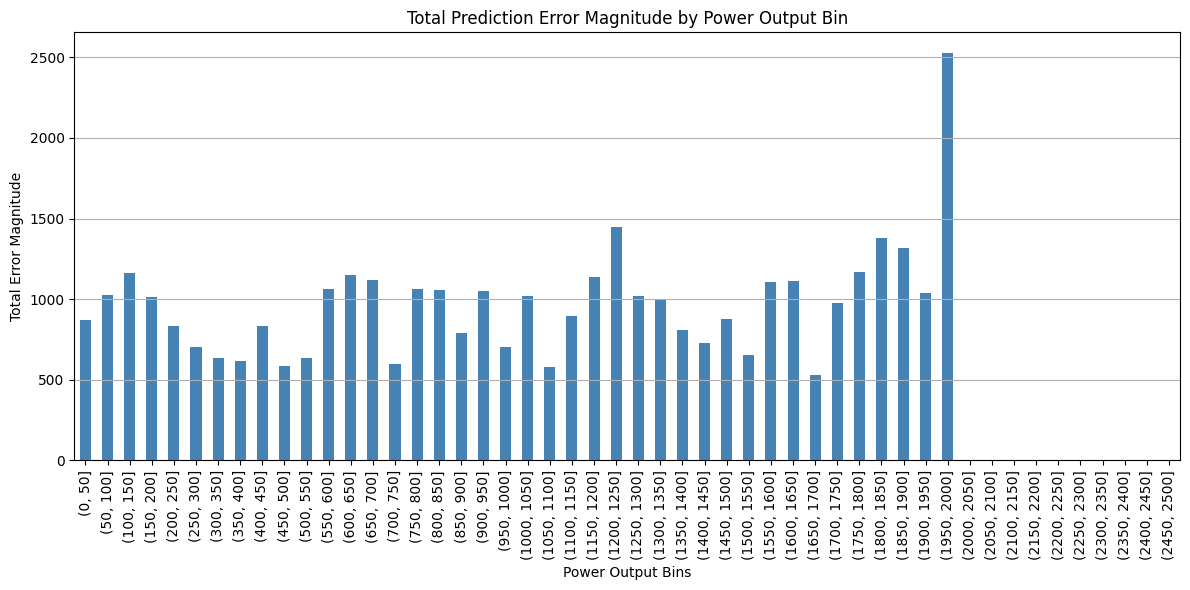

In [380]:
# Optional binning (e.g., 50 kW bins)
filtered_df["power_bin"] = pd.cut(
    filtered_df[target_column], bins=range(0, 2501, 50)
)

# Then group and plot as above
error_magnitude_by_power_bin = filtered_df.groupby("power_bin")["abs_residual"].sum()

plt.figure(figsize=(12, 6))
error_magnitude_by_power_bin.plot(kind='bar', color='steelblue')
plt.xlabel("Power Output Bins")
plt.ylabel("Total Error Magnitude")
plt.title("Total Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3055368067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["power_bin"] = pd.cut(
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3055368067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["abs_residual"] = (
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3055368067.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

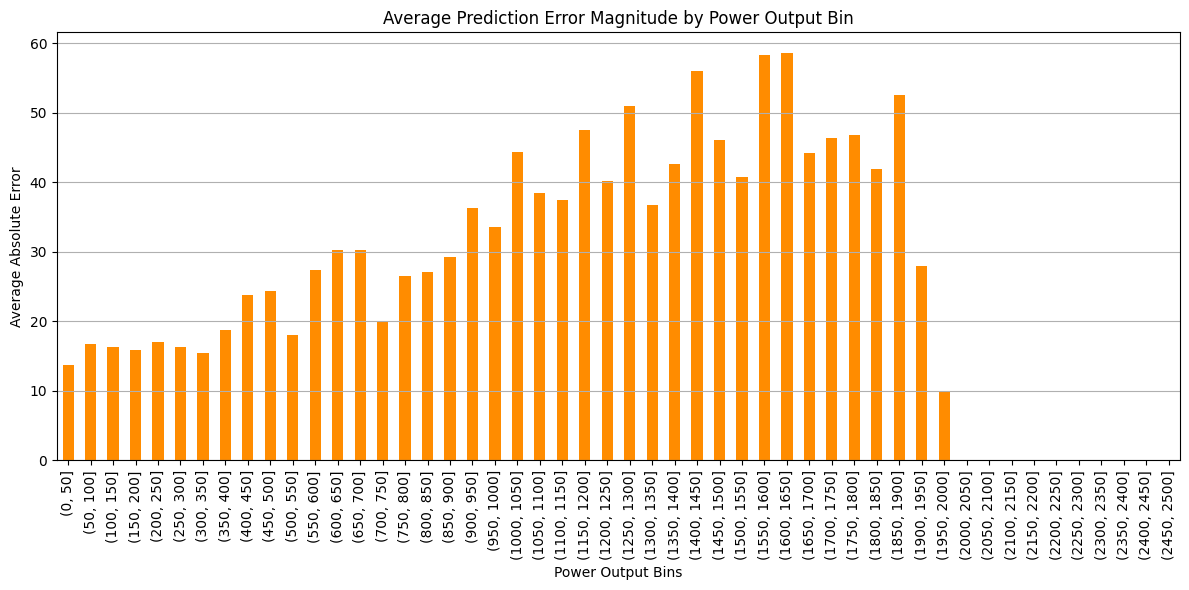

In [381]:
# Bin power output (e.g., 50 kW bins)
filtered_df["power_bin"] = pd.cut(
    filtered_df[target_column], bins=range(0, 2501, 50)
)

# Compute absolute residuals if not already done
filtered_df["abs_residual"] = (
    filtered_df["residual"].abs()
)

# Group by power bin and calculate mean error
avg_error_by_bin = filtered_df.groupby("power_bin")["abs_residual"].mean()

# Plot
plt.figure(figsize=(12, 6))
avg_error_by_bin.plot(kind='bar', color='darkorange')
plt.xlabel("Power Output Bins")
plt.ylabel("Average Absolute Error")
plt.title("Average Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\920066315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["power_bin"] = pd.cut(
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\920066315.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_magnitude_by_power_bin = filtered_df.groupby("power_bin")["abs_residual"].sum()


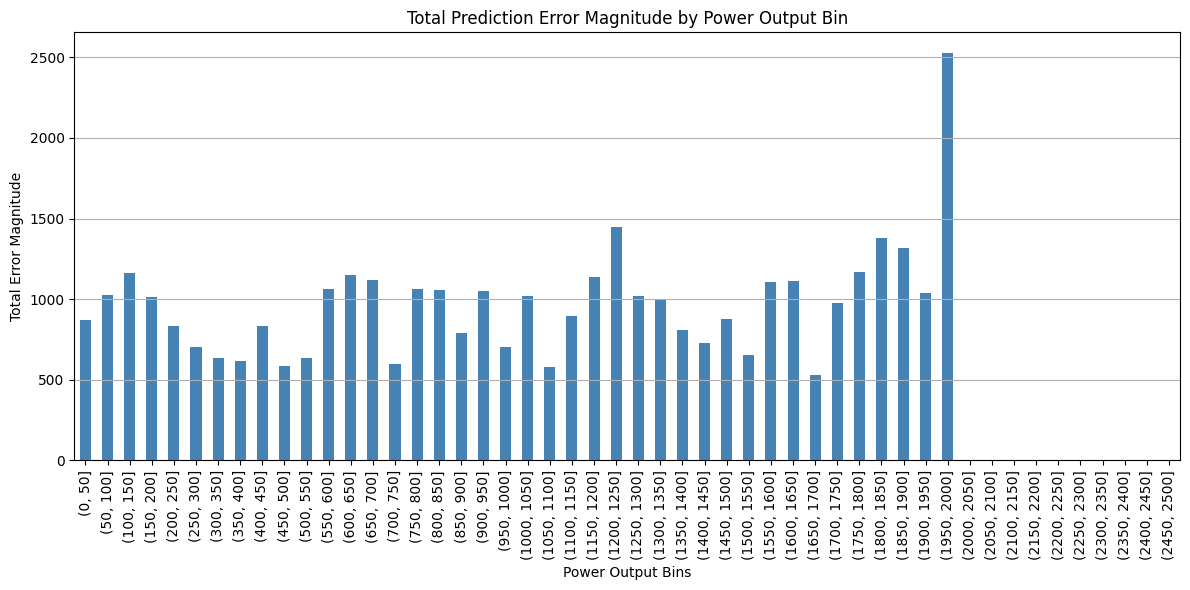

In [382]:
# Optional binning (e.g., 50 kW bins)
filtered_df["power_bin"] = pd.cut(
    filtered_df[target_column], bins=range(0, 2501, 50)
)

# Then group and plot as above
error_magnitude_by_power_bin = filtered_df.groupby("power_bin")["abs_residual"].sum()

plt.figure(figsize=(12, 6))
error_magnitude_by_power_bin.plot(kind='bar', color='steelblue')
plt.xlabel("Power Output Bins")
plt.ylabel("Total Error Magnitude")
plt.title("Total Prediction Error Magnitude by Power Output Bin")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Inference period

C:\Users\thors\AppData\Local\Temp\ipykernel_37340\1041400802.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = (


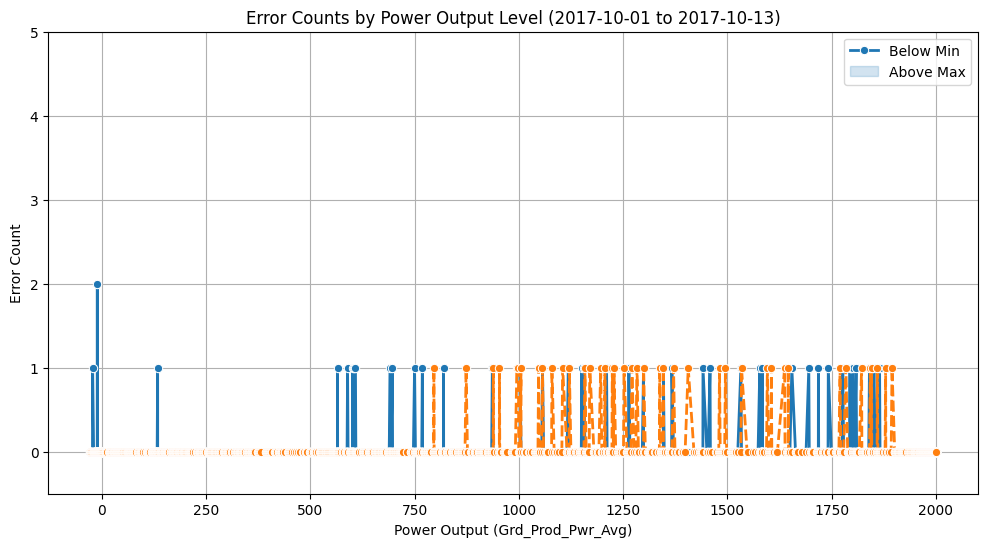

In [383]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the time window
start_date = "2017-10-01"
end_date = "2017-10-13"

# Filter the DataFrame by Timestamp
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) & 
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residual errors within the time window
time_filtered_df["residual"] = (
    time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
)

# Count errors (above_max and below_min) by power level within the time window
error_counts = time_filtered_df.groupby(target_column)[["below_min", "above_max"]].sum()

# Plot the error counts against power levels
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_counts, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Error Count")
plt.title(f"Error Counts by Power Output Level ({start_date} to {end_date})")
plt.legend(["Below Min", "Above Max"])
plt.grid(True)
plt.ylim(-0.5, 5)
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3910594825.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3910594825.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()


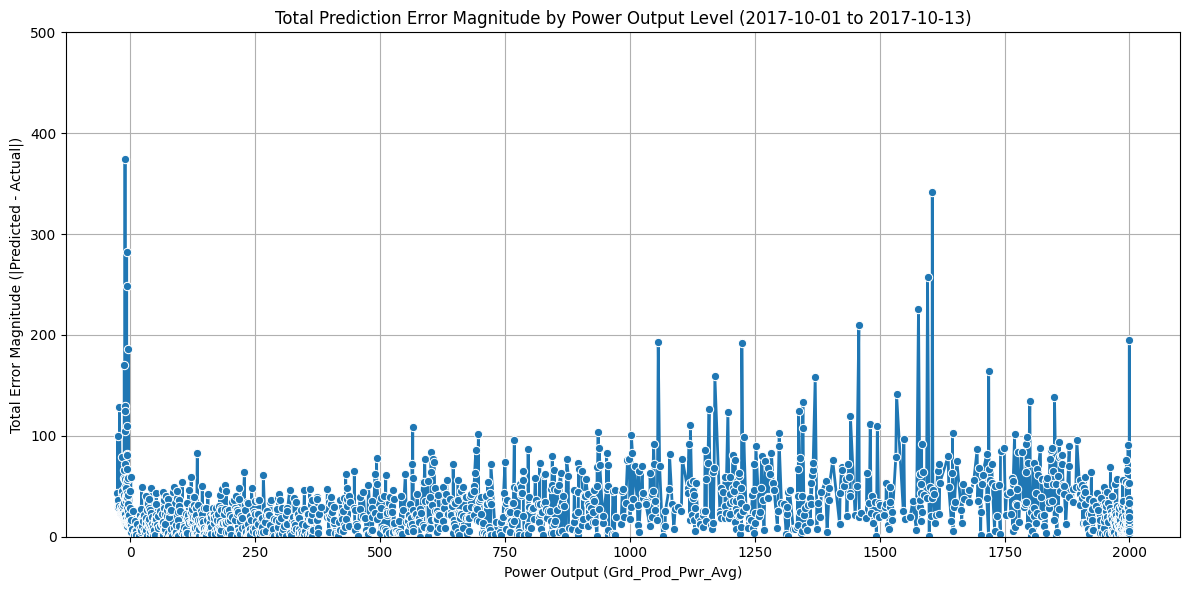

In [384]:
import seaborn as sns
import matplotlib.pyplot as plt

# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residuals
time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()

# Group by power output
error_magnitude_by_power = time_filtered_df.groupby(target_column)["abs_residual"].sum()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_magnitude_by_power, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Total Error Magnitude (|Predicted - Actual|)")
plt.title(f"Total Prediction Error Magnitude by Power Output Level ({start_date} to {end_date})")
plt.grid(True)
plt.ylim(0, 500)
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\924039631.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\924039631.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\924039631.py:14: SettingWithCopyWarning: 
A value is trying to 

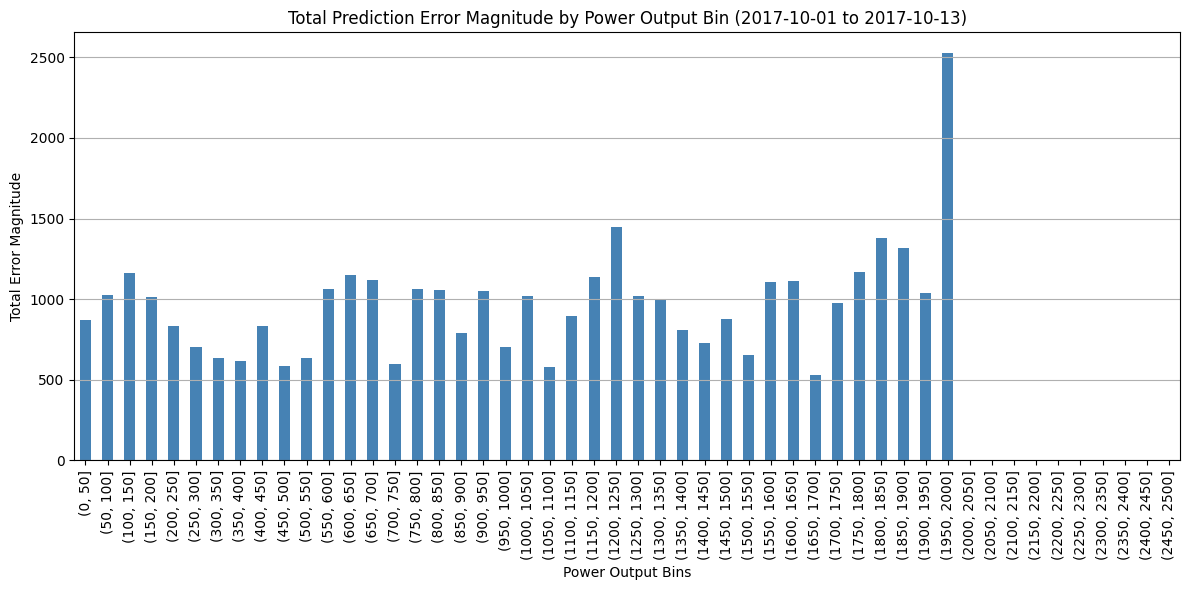

In [385]:
# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residuals
time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]
time_filtered_df["abs_residual"] = time_filtered_df["residual"].abs()

# Bin power levels
time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))

# Group and plot
error_magnitude_by_power_bin = time_filtered_df.groupby("power_bin")["abs_residual"].sum()

plt.figure(figsize=(12, 6))
error_magnitude_by_power_bin.plot(kind='bar', color='steelblue')
plt.xlabel("Power Output Bins")
plt.ylabel("Total Error Magnitude")
plt.title(f"Total Prediction Error Magnitude by Power Output Bin ({start_date} to {end_date})")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\2009701568.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]


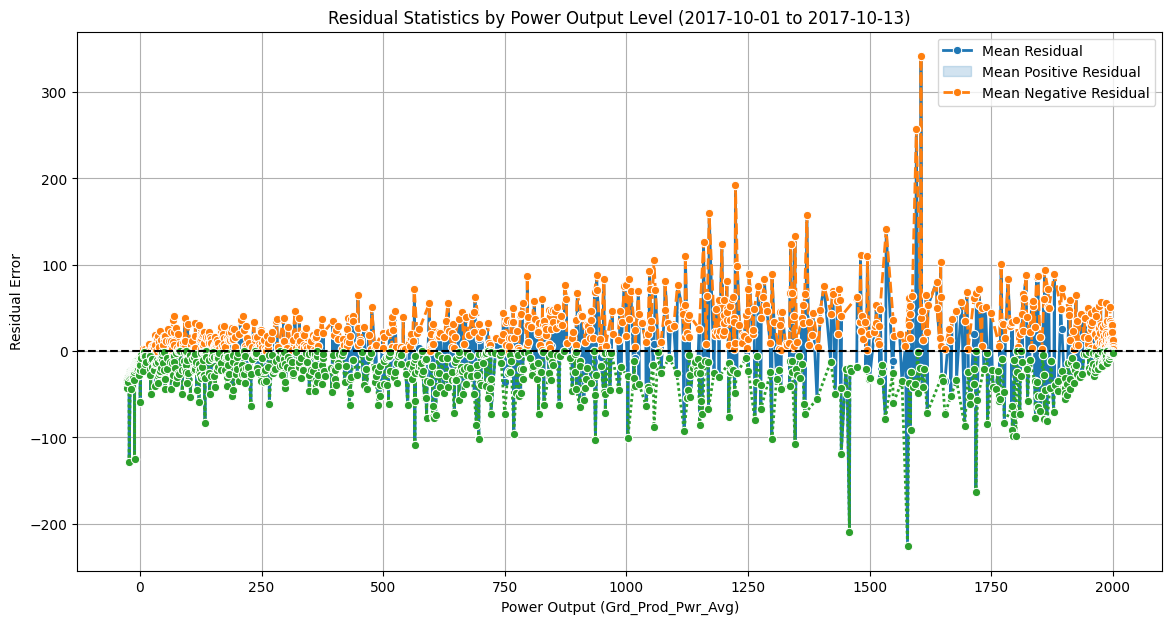

In [386]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Compute residuals
time_filtered_df["residual"] = time_filtered_df[target_column] - time_filtered_df["xgboost_pred_2017"]

# Stats
residual_stats = time_filtered_df.groupby(target_column)["residual"].agg(
    mean_residual="mean",
    std_residual="std",
    count="count"
)

positive_residuals = time_filtered_df[time_filtered_df["residual"] > 0]
negative_residuals = time_filtered_df[time_filtered_df["residual"] < 0]

positive_stats = positive_residuals.groupby(target_column)["residual"].agg(mean_positive="mean")
negative_stats = negative_residuals.groupby(target_column)["residual"].agg(mean_negative="mean")

residual_stats = residual_stats.join(positive_stats).join(negative_stats)

# Plot
plt.figure(figsize=(14, 7))
sns.lineplot(data=residual_stats[["mean_residual", "mean_positive", "mean_negative"]], marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Residual Error")
plt.title(f"Residual Statistics by Power Output Level ({start_date} to {end_date})")
plt.legend(["Mean Residual", "Mean Positive Residual", "Mean Negative Residual"])
plt.grid(True)
plt.axhline(0, color="black", linestyle="--")
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\2908255443.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\2908255443.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  anomaly_counts = time_filtered_df.groupby("power_bin")[["below_min", "above_max"]].sum()


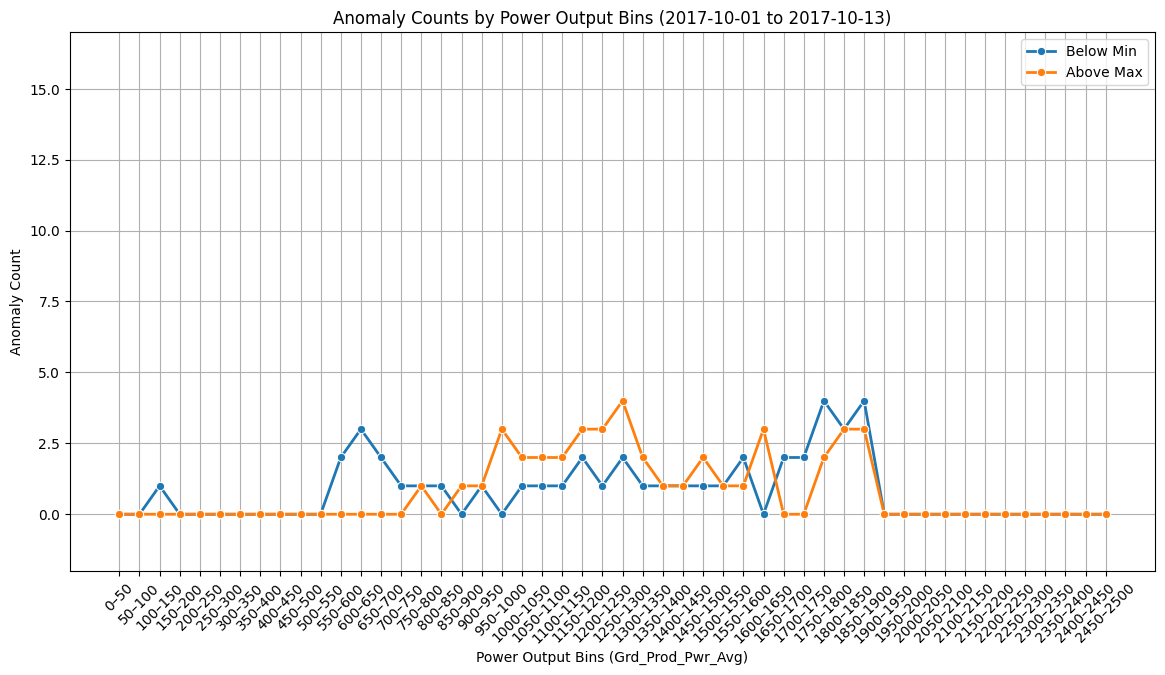

In [387]:
# Time filter
start_date = "2017-10-01"
end_date = "2017-10-13"
time_filtered_df = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= start_date) &
    (merged_df_filtered17_sorted["Timestamp"] <= end_date)
]

# Ensure power_bin column exists
time_filtered_df["power_bin"] = pd.cut(time_filtered_df[target_column], bins=range(0, 2501, 50))

# Step 1: Group and reset
anomaly_counts = time_filtered_df.groupby("power_bin")[["below_min", "above_max"]].sum()
anomaly_counts_reset = anomaly_counts.reset_index()

# Step 2: Convert bin to label
anomaly_counts_reset["power_bin_str"] = anomaly_counts_reset["power_bin"].apply(lambda x: f"{int(x.left)}–{int(x.right)}")

# Step 3: Plot
plt.figure(figsize=(14, 7))
sns.lineplot(x="power_bin_str", y="below_min", data=anomaly_counts_reset, marker="o", linewidth=2, label="Below Min")
sns.lineplot(x="power_bin_str", y="above_max", data=anomaly_counts_reset, marker="o", linewidth=2, label="Above Max")

plt.xlabel("Power Output Bins (Grd_Prod_Pwr_Avg)")
plt.ylabel("Anomaly Count")
plt.title(f"Anomaly Counts by Power Output Bins ({start_date} to {end_date})")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.ylim(-2, 17)
plt.show()


# Note to self
## I morra må eg finne en måte å måle: 
- kor tett intervallet er på en graf OG MULIGENS mot hvor mange anomalies den får
- Sjekke time domain plots modelling error og interval analysis individuelt


- std av hver bin
- mindre bins?

C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3964190779.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_error_stats = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].agg(
C:\Users\thors\AppData\Local\Temp\ipykernel_37340\3964190779.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  modeling_error_stats = merged_df_filtered17_sorted.groupby("pred_bin")["modeling_spread"].agg(


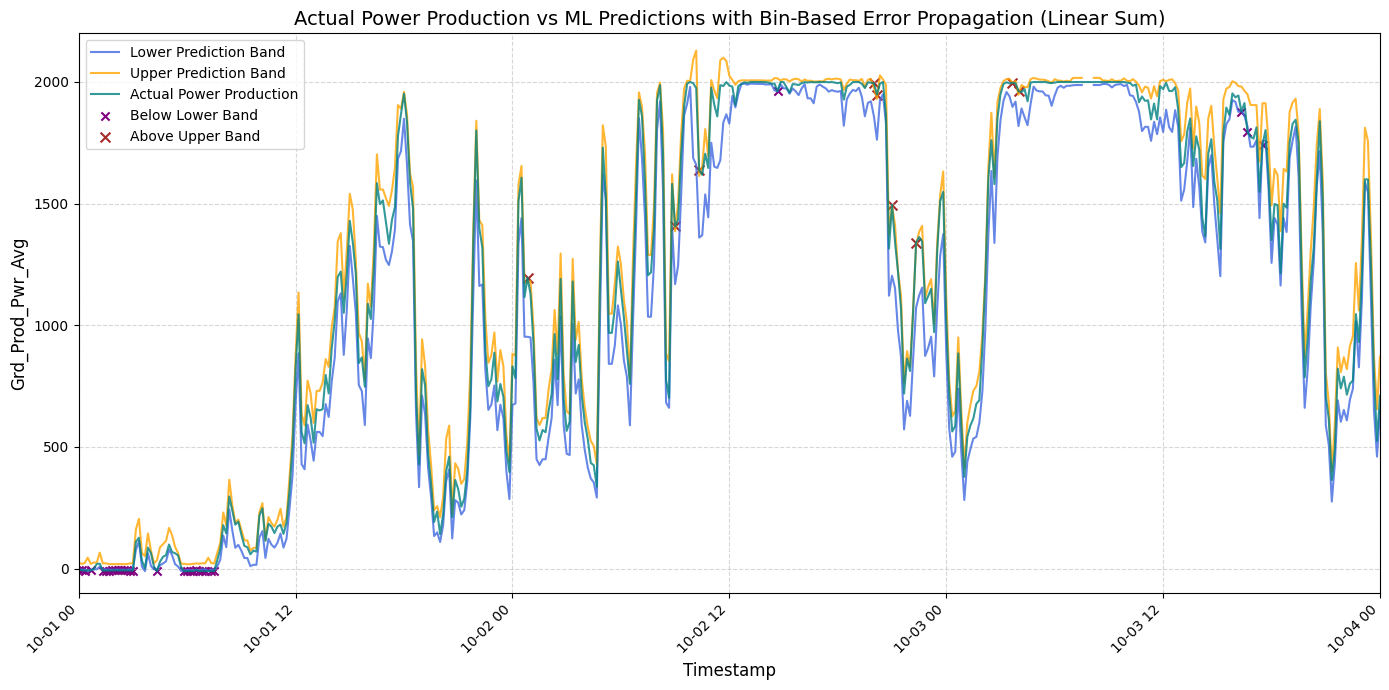

In [388]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is datetime
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute absolute residuals (actual - predicted)
target_column = "Grd_Prod_Pwr_Avg"
merged_df_filtered17_sorted["abs_residual"] = (
    (merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]).abs()
)

# Compute modeling spread (max - min from sensitivity predictions)
merged_df_filtered17_sorted["modeling_spread"] = (
    merged_df_filtered17_sorted[prediction_columns].max(axis=1) - 
    merged_df_filtered17_sorted[prediction_columns].min(axis=1)
)

# Define bin edges based on data min and max (with a little buffer)
bin_width = 5
min_power = int(np.floor(merged_df_filtered17_sorted[[target_column, "xgboost_pred_2017"]].min().min() // bin_width) * bin_width)
max_power = int(np.ceil(merged_df_filtered17_sorted[[target_column, "xgboost_pred_2017"]].max().max() // bin_width) * bin_width)

# Create bins
bin_edges = range(min_power, max_power + bin_width, bin_width)

# Bin actual power output
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=bin_edges, include_lowest=True
)

# Compute mean, 5th and 95th percentile residuals per bin
bin_error_stats = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].agg(
    mean_error="mean",
    p5_error=lambda x: x.quantile(0.05),
    p95_error=lambda x: x.quantile(0.95)
).reset_index()

# Bin predicted values
merged_df_filtered17_sorted["pred_bin"] = pd.cut(
    merged_df_filtered17_sorted["xgboost_pred_2017"], bins=bin_edges, include_lowest=True
)

# Compute mean, 5th and 95th percentile modeling spread per bin
modeling_error_stats = merged_df_filtered17_sorted.groupby("pred_bin")["modeling_spread"].agg(
    mean_spread="mean",
    p5_spread=lambda x: x.quantile(0.05),
    p95_spread=lambda x: x.quantile(0.95)
).reset_index()

# Merge bin-based residual error stats
merged_df_filtered17_sorted = merged_df_filtered17_sorted.merge(
    bin_error_stats, left_on="pred_bin", right_on="power_bin", how="left"
)

# Merge bin-based modeling spread stats
merged_df_filtered17_sorted = merged_df_filtered17_sorted.merge(
    modeling_error_stats, on="pred_bin", how="left"
)



"""# Calculate row_min and row_max using LINEAR SUM of bin-based modeling spread and residual error
merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    (
        (merged_df_filtered17_sorted["mean_spread"] / 2) + 
        merged_df_filtered17_sorted["mean_error"]
    )
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    (
        (merged_df_filtered17_sorted["mean_spread"] / 2) + 
        merged_df_filtered17_sorted["mean_error"]
    )
)
"""

"""merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"]) + 
    merged_df_filtered17_sorted["mean_error"]
)


merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    (merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1)) - 
    merged_df_filtered17_sorted["mean_error"]
)"""


merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] -
    np.sqrt(
        (merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 +
        merged_df_filtered17_sorted["mean_error"]**2
    )
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] +
    np.sqrt(
        (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 +
        merged_df_filtered17_sorted["mean_error"]**2
    )
)






# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plot actual, prediction bands, and outliers
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["row_min"],
    color='royalblue', alpha=0.8, label='Lower Prediction Band', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["row_max"],
    color='orange', alpha=0.8, label='Upper Prediction Band', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual Power Production', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label='Below Lower Band'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label='Above Upper Band'
)

# Clean up plot
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-04'))
plt.title("Actual Power Production vs ML Predictions with Bin-Based Error Propagation (Linear Sum)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.ylim(-100, 2200)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [389]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is datetime
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute absolute residuals (actual - predicted)
target_column = "Grd_Prod_Pwr_Avg"  # replace with your actual target column name
merged_df_filtered17_sorted["abs_residual"] = (
    (merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]).abs()
)

# Bin actual power output (50 kW bins)
merged_df_filtered17_sorted["power_bin"] = pd.cut(
    merged_df_filtered17_sorted[target_column], bins=range(0, 2501, 50)
)

# Compute mean, 5th and 95th percentile residuals per bin
bin_error_stats = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].agg(
    mean_error="mean"
).reset_index()

# Bin the predicted values the same way
merged_df_filtered17_sorted["pred_bin"] = pd.cut(
    merged_df_filtered17_sorted["xgboost_pred_2017"], bins=range(0, 2501, 50)
)

# Merge bin error stats based on predicted bin
merged_df_filtered17_sorted = merged_df_filtered17_sorted.merge(
    bin_error_stats, left_on="pred_bin", right_on="power_bin", how="left"
)

# Calculate row_min and row_max using mean error per bin
merged_df_filtered17_sorted["row_min"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] - 
    np.sqrt(
        (merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + 
        merged_df_filtered17_sorted["mean_error"]**2
    )
)

merged_df_filtered17_sorted["row_max"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"] + 
    np.sqrt(
        (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + 
        merged_df_filtered17_sorted["mean_error"]**2
    )
)

# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"])
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"])
).astype(int)

# Plot actual, prediction bands, and outliers
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)

# Clean up plot
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))
plt.title("Actual Power Production vs ML Predictions with Bin-Based Error Propagation Intervals", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\thors\AppData\Local\Temp\ipykernel_37340\742782834.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_error_stats = merged_df_filtered17_sorted.groupby("power_bin")["abs_residual"].agg(


MergeError: Passing 'suffixes' which cause duplicate columns {'power_bin_x'} is not allowed.